## Import

In [1]:
import frgtools.misc as frgm
import frgtools.plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.signal import chirp, find_peaks, peak_widths
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally


import matplotlib.colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

# divider = make_axes_locatable(ax_)

## Functions

In [2]:
import os
import numpy as np
from tqdm import tqdm


def modified_z_score(intensity):
    median_int = np.median(intensity)
    mad_int = np.median([np.abs(intensity -median_int)])
    modified_z_scores = 0.6745 * (intensity- median_int) / mad_int
    return modified_z_scores

def fixer(y,m=3, th=7):
    try:
        th = 7 # binarization threshold. 
        spikes = abs(np.array(modified_z_score(np.diff(y)))) > th
        y_out = y.copy() # So we don’t overwrite y
        for i in np.arange(len(spikes)):
            if spikes[i] != 0: # If we have an spike in position i
                w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
                w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_out[i] = np.mean(y[w2]) # and we average their values
    except:
        m = 1
        th = 7 # binarization threshold. 
        spikes = abs(np.array(modified_z_score(np.diff(y)))) > th
        y_out = y.copy() # So we don’t overwrite y
        for i in np.arange(len(spikes)):
            if spikes[i] != 0: # If we have an spike in position i
                w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
                w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_out[i] = np.mean(y[w2]) # and we average their values        
 
    return y_out

def shifttonm(shift, incident_wl):
    '''
    converts a raman shift (cm-1) to wavelength (nm)

    inputs
        shift: raman shift, cm-1
        incident_wl: excitation source wavelength, nm

    output
        emitted wavelength, nm
    '''
    incident_wn = 1/(incident_wl * 1e-7)
    exit_wn = incident_wn - shift
    return 1e7/exit_wn 

def nmtoshift(wl, incident_wl):
    '''
    converts an emitted wavelength (nm) to raman shift (cm-1)

    inputs
        wl: emitted wavelength, nm
        incident_wl: excitation source wavelength, nm

    output
        shift: raman shift, cm-1
    '''
    incident_wn = 1/(incident_wl * 1e-7)
    exit_wn = 1/(wl * 1e-7)
    return incident_wn - exit_wn

def load_renishaw(path, incident_wl):
    '''
    Loads raw spectra files output when exporting renishaw area scans to xy data.
    Assumes input data is in raman shift (cm-1)

    inputs:
        path: path to folder holding all raw xy files
        incident_wl: excitation source wavelength, nm

    output:
        dictionary with consolidated area scan data

    '''
#     LP = 695 # low pass filter index      

    fids = [os.path.join(path, x) for x in os.listdir(path)]
    allx = []
    ally = []
    for f in fids:
        allx.append(float(f.split('X')[-1].split('_')[1]))
        ally.append(float(f.split('Y')[-1].split('_')[1]))
    allx = np.array(allx)
    ally = np.array(ally)
    x = np.unique(allx)
    y = np.unique(ally)
    x.sort()
    y.sort()
    
    temp = np.loadtxt(fids[0])#,max_rows=LP)
    shift = temp[:,0]
    wl = nmtoshift(shift, incident_wl = incident_wl)

    wl = shifttonm(wl, incident_wl = incident_wl)
    
#     wl = incident_wl
    cts = np.zeros((len(y), len(x), len(wl)))
    for f, x_, y_ in tqdm(zip(fids, allx, ally), total = len(fids), desc = 'Loading Renishaw Scans', leave = False):
        m = np.where(y == y_)
        n = np.where(x == x_)
        cts[m,n] = np.loadtxt(f)[:,1]    
    
    extent = [x[0], x[-1], y[0], y[-1]]

    results = {
        'shift': temp[:,0],
        'incidentWavelength': incident_wl,
        'wavelengths': wl,
        'counts': cts,
        'intensity': cts.max(axis = 2),
        'peakWavelength': wl[np.argmax(cts, axis = 2)],
        'x': x,
        'y': y,
        'extent': extent
    }

    return results


def load_renishaw_tseries(path, incident_wl):
    fids = [os.path.join(path, x) for x in os.listdir(path)]
    fids = sorted(fids)
    episode = []
    for f in fids:
        episode.append(float(f.split('_')[-1].split('.txt')[0]))
    t = np.array(episode)
#     t.sort()
    temp = np.loadtxt(fids[0], skiprows=0)
    shift = temp[:,0]
    
    wl = nmtoshift(shift, incident_wl = incident_wl)

    wl = shifttonm(wl, incident_wl = incident_wl)
#     shift = temp[:,0]
#     wl = nmtoshift(shift, incident_wl = incident_wl)
#     wl = shift
#     wl = shifttonm(shift, incident_wl = incident_wl)    
#     counts = temp[:,1]
    cts = np.zeros((len(t), len(wl)))
    

    for f, t_, in tqdm(zip(fids, t), total = len(fids), desc = 'Loading Time Series', leave = False):
        n = np.where(t == t_)
#         cts[n] = np.loadtxt(f, skiprows =0, max_rows=LP)[:,1]  
        cts[n] = np.loadtxt(f, skiprows =0)[:,1]  

        
         
    results = {
        'wl': wl,
        'time': t,
        'counts': cts#-bg_smooth
    }
    return results

In [3]:
rootdir = os.path.join('/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK') #replace this with the filepath to root directory for the experiment
bg = os.path.join(rootdir, 'bg')
raw = os.path.join(rootdir, 'raw')
extra = os.path.join(rootdir, 'extra')
tseries = os.path.join(rootdir, 'tseries')

In [4]:
fids = []
for f in frgm.listdir(tseries, display = False):
    if 'control' in f and '_rgb' not in f:
        continue
    fids.append(f)
fids

['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/01_Glass_B_p0-5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/08_Glass_C_p1',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/09_Glass_C_p5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/10_Glass_D_p0-5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/05_Glass_A_p1',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/11_Glass_D_p1',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/03_Glass_B_p5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RA

In [5]:
sorted(fids)

['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/01_Glass_B_p0-5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/02_Glass_B_p1',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/03_Glass_B_p5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/04_Glass_A_p0-5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/05_Glass_A_p1',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/06_Glass_A_p5',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/PL-µPL_MRC/20210820_IlluminationDecay_Inorganic_DC_MK/tseries/07_Glass_C_p0-5',
 '/Volumes/GoogleDrive/My Drive/Characterization_

In [6]:
df=pd.DataFrame(index=['wl', 'time', 'counts'], columns=[f.split('/')[8] for f in fids])
n=0
for column in df:
    data = load_renishaw_tseries(fids[n], 633)
    tempdf=pd.DataFrame(data.items(), index=['wl', 'time', 'counts'])
    df[column] = tempdf[1]
    n=n+1
df = df.transpose()


df['name'] = ''
n= 0
for n in range(0, df.shape[0]):
    df['name'][fids[n].split('/')[8]] = fids[n].split('/')[8]

In [7]:
df

,wl,time,counts,name
01_Glass_B_p0-5,"[757.4482419999999, 757.275391, 757.1025999999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[48.957355, 42.319069, 43.959213, 44.768837, ...",01_Glass_B_p0-5
08_Glass_C_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[104.796196, 102.240189, 98.789085, 90.233398...",08_Glass_C_p1
09_Glass_C_p5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[460.080841, 471.15686, 456.473694, 488.62237...",09_Glass_C_p5
10_Glass_D_p0-5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 300.0, 361.0,...","[[52.824097, 45.156082, 51.097801, 44.265442, ...",10_Glass_D_p0-5
05_Glass_A_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[109.908203, 107.352196, 110.711906, 104.7047...",05_Glass_A_p1
11_Glass_D_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[80.940147, 93.720169, 85.163002, 85.977112, ...",11_Glass_D_p1
03_Glass_B_p5,"[757.4482419999999, 757.275391, 757.1025999999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[394.148193, 401.616272, 386.509308, 412.0390...",03_Glass_B_p5
06_Glass_A_p5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[707.161316, 695.233276, 668.529541, 708.2470...",06_Glass_A_p5
12_Glass_D_p5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[414.924774, 415.776764, 437.737823, 424.7779...",12_Glass_D_p5
02_Glass_B_p1,"[757.4482419999999, 757.275391, 757.1025999999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[65.55307, 75.510498, 64.694687, 75.443779, 6...",02_Glass_B_p1


In [234]:
name_key = {
    'A': '10',
    'B': '5',
    'C': '1',
    'D': '0',

    'p0-5': '19 Suns',
    'p5': '190 Suns',
    'p1': '39 Suns'
}

def getname_0(n): #ETL
    letter = n.split('_')[2]
    return name_key[letter]

def getname_1(n): #HTL
    letter_1 = n.split('_')[3]
    return name_key[letter_1]

# def getname_3(n): #HTL
#     letter_3 = n.split('_')[1]
#     return name_key[letter_3]

df['Chlorine_Loading'] = ''
df['Energy_Flux'] = ''
# df['dir'] = ''
# df['condition'] = ''



# for n in range(df.shape[0]):
#     df['dspacing'][n] = theta_to_d(df['angles'][n]
    
# df['ETL'] = df['name'].apply(getname)
df['Chlorine_Loading'] = df['name'].apply(getname_0)
df['Energy_Flux'] = df['name'].apply(getname_1)

for n in range(df.shape[0]):
    df['Chlorine_Loading'][n] = int(df['Chlorine_Loading'][n])

In [235]:
# df = df.sort_values(by=['Energy_Flux'],  ascending=False)

df = df.sort_values(by=['name'],  ascending=False)

sample_list = ['literallyanything' for i in range(df.shape[0])]
for n in range(df.shape[0]):
    sample_list[n] = fids[n].split('/')[8]
sample_list = sorted(sample_list)

In [236]:
for n in range(df.shape[0]):
    sample = sample_list[n]
    LP_temp = np.max(np.where(df['wl'][sample] >= 645))
    df['wl'][sample] = df['wl'][sample][:LP_temp]
    df['counts'][sample] = df['counts'][sample][:, :LP_temp]

#     df['counts'][sample] = 
#     for q in range(df['counts'][sample].shape[0]):
#         df['counts'][sample][q] = df['counts'][sample][q][:LP_temp]

In [237]:
# df['counts_bgsubt'] = df['counts']

# for n in range(df.shape[0]): #for every sample
#     sample = sample_list[n]
#     for q in range(df['counts_bgsubt'][sample].shape[0]): #for every time point
#         df['counts_bgsubt'][sample][q] = df['counts_bgsubt'][sample][q] - np.min(df['counts_bgsubt'][sample][q])

In [238]:
df['counts_despiked'] = df['counts'] #df['counts_bgsubt']

for n in range(df.shape[0]):
    sample = sample_list[n]
    for q in range(df['counts_despiked'][sample].shape[0]):
        df['counts_despiked'][sample][q] = fixer(df['counts_despiked'][sample][q])#, m=3, th=7)

In [239]:

#wf plots
# embiggen = 10
# horiz = 1
# vert = df.shape[0]
# from matplotlib.colors import LogNorm

# y_value = df['counts_despiked']


# # cm1 = 'inferno'
# # cm2 = 'Greys'
# fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))

# # for n, ax_ in zip(range(0, len(list_of_files)), ax.ravel()):
# for n, ax_ in zip(range(0, df.shape[0]), ax.ravel()):
#     im= ax_.imshow(y_value[sample_list[n]], extent=[df['wl'][fids[n].split('/')[8]][0], 
#                                                                 df['wl'][fids[n].split('/')[8]][-1],
#                                                                 481,0],
#                                                                 aspect = 'auto')
# #                                                                 df['time'][fids[n].split('/')[8]][0]*2,
# #                                                                 df['time'][fids[n].split('/')[8]][-1]*2])#, norm=LogNorm( vmax=5000))

#     ax_.set_ylabel('Time minutes')
#     ax_.set_xlabel('λ nm')
#     ax_.set_title(sample_list[n])
# #     ax_.set_yticklabels([])
# #     ax_.set_xticklabels([])

# #     ax_.set_xticklabels([5000, 4000, 3000, 2000, 450])
# #     ax_.invert_yaxis()
#     divider = make_axes_locatable(ax_)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbar = plt.colorbar(im, cax=cax)
# #     cbar.mappable.set_clim(0, 2**16)
# #     ax_.set_xlim(300,800)
# # try plotting color in log scale 

# plt.show()

## Looking at averaged counts

In [240]:
from functools import partial #https://docs.python.org/2/library/functools.html
from scipy.signal import savgol_filter

def average_counts(x):
    return np.mean(x, axis=0)

window = 71
order = 3

In [241]:
y_value = df['counts_despiked']

df['tseries_avg'] = y_value.apply(average_counts)
df['tseries_avg_smooth'] = df['tseries_avg'].apply(
    partial(savgol_filter, window_length = window, polyorder = order)
)

df['tseries_smooth'] = y_value
df['tseries_smooth'] = df['tseries_smooth'].apply(
    partial(savgol_filter, window_length = window, polyorder = order)
)

In [242]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = 'p1'
Filter_2 = ''
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
count = 0

for n in df_filter3['name'].unique(): 
    print(n)
    count +=1
print(count)

subset_sample_list = list(df_filter3['name'].unique())

# subset_sample_list = ['literallyanything' for i in range(count)]
# for n in range(count):
#     subset_sample_list[n] = fids[n].split('/')[8]
# sample_list = sorted(sample_list)

11_Glass_D_p1
08_Glass_C_p1
05_Glass_A_p1
02_Glass_B_p1
4


In [243]:
# data.columns

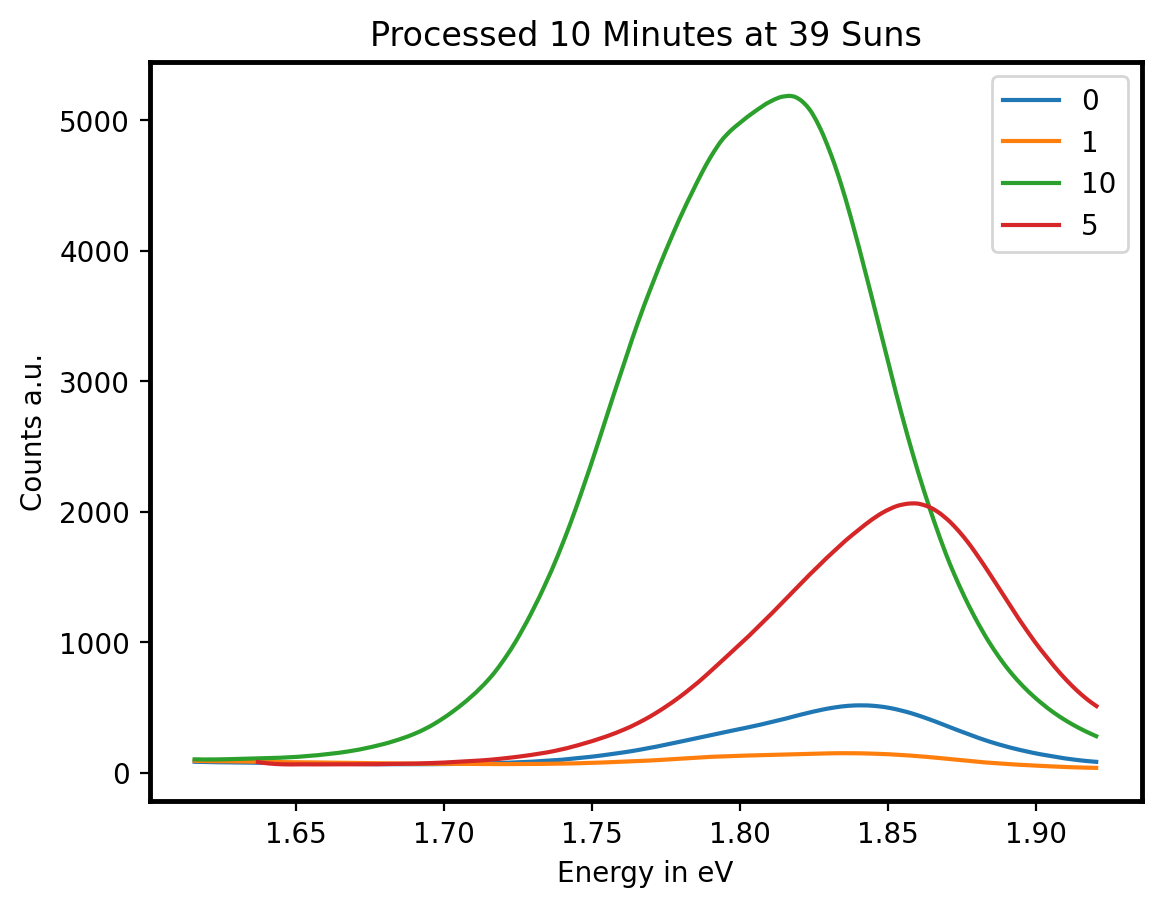

In [244]:
data = df_filter3

# color_choice = ['blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red']#, 'black']#, 'red', 'red', 'blue', 'blue']
# line_choice = ['-', '--', '-', '--', '--', '-', '-', '--', '-', '--', '--']



for n in range(data.shape[0]):
#     if 1 <= n <= 1:
#         continue
#     if data['Chlorine_loading'][n] == 'Dark-Side':
#         color_choice = 'black'
#     if data['side'][n] == 'Sunny-Side':
#         color_choice = 'red'
        
    plt.plot(1240/data['wl'][n], 
             data['tseries_avg_smooth'][n],# - df_bg['tseries_avg_smooth']['BG_5s_dwell'],
             label=(str(data['Chlorine_Loading'][n]))
#              color = color_choice,
#              linestyle= line_choice[n]            
            )

    
# plt.plot(df['wl']['NHTL'],df['tseries_avg_smooth']['NHTL'], label='NHTL')
# plt.plot(df['wl']['P3BT'],df['tseries_avg_smooth']['P3BT'], label='P3BT')
# plt.plot(df['wl']['P3HT'],df['tseries_avg_smooth']['P3HT'], label='P3HT')
# plt.plot(df['wl']['PTAA'],df['tseries_avg_smooth']['PTAA'], label='PTAA')

plt.legend()
# plt.xlim(200, 750)
# plt.ylim(-500,6000)
plt.xlabel('Energy in eV')
plt.ylabel('Counts a.u.')
plt.title('Processed 10 Minutes at '+ data['Energy_Flux'][0])
plt.show()

## Binned Counts

In [269]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = 'A'
Filter_2 = ''
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
# df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
count = 0
for n in df_filter3['name'].unique(): 
    print(n)
    count += 1
    

print(count)

subset_sample_list = list(df_filter3['name'].unique())
df_filter3 = df_filter3.sort_values(by=['Chlorine_Loading'],  ascending=True)


06_Glass_A_p5
05_Glass_A_p1
04_Glass_A_p0-5
3


In [270]:
df_filter3

,wl,time,counts,name,Chlorine_Loading,Energy_Flux,counts_despiked,tseries_avg,tseries_avg_smooth,tseries_smooth
06_Glass_A_p5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[707.161316, 695.233276, 668.529541, 708.2470...",06_Glass_A_p5,10,190 Suns,"[[707.161316, 695.233276, 668.529541, 708.2470...","[581.4437257777778, 586.4610798888889, 575.512...","[585.4999842987708, 585.5000134193956, 585.625...","[[691.958927041165, 695.3732926600031, 698.867..."
05_Glass_A_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[109.908203, 107.352196, 110.711906, 104.7047...",05_Glass_A_p1,10,39 Suns,"[[109.908203, 107.352196, 110.711906, 104.7047...","[101.57751966666667, 101.00951977777778, 104.3...","[103.94518566596356, 103.74568226616115, 103.5...","[[109.15754761285162, 108.85101860879828, 108...."
04_Glass_A_p0-5,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[62.196114, 52.824097, 61.31736, 56.18306, 62...",04_Glass_A_p0-5,10,19 Suns,"[[62.196114, 52.824097, 61.31736, 56.18306, 62...","[55.75876922222221, 55.66410233333333, 56.3968...","[57.31489290994126, 57.28362916081635, 57.2558...","[[58.68073933379135, 58.53446797727833, 58.400..."


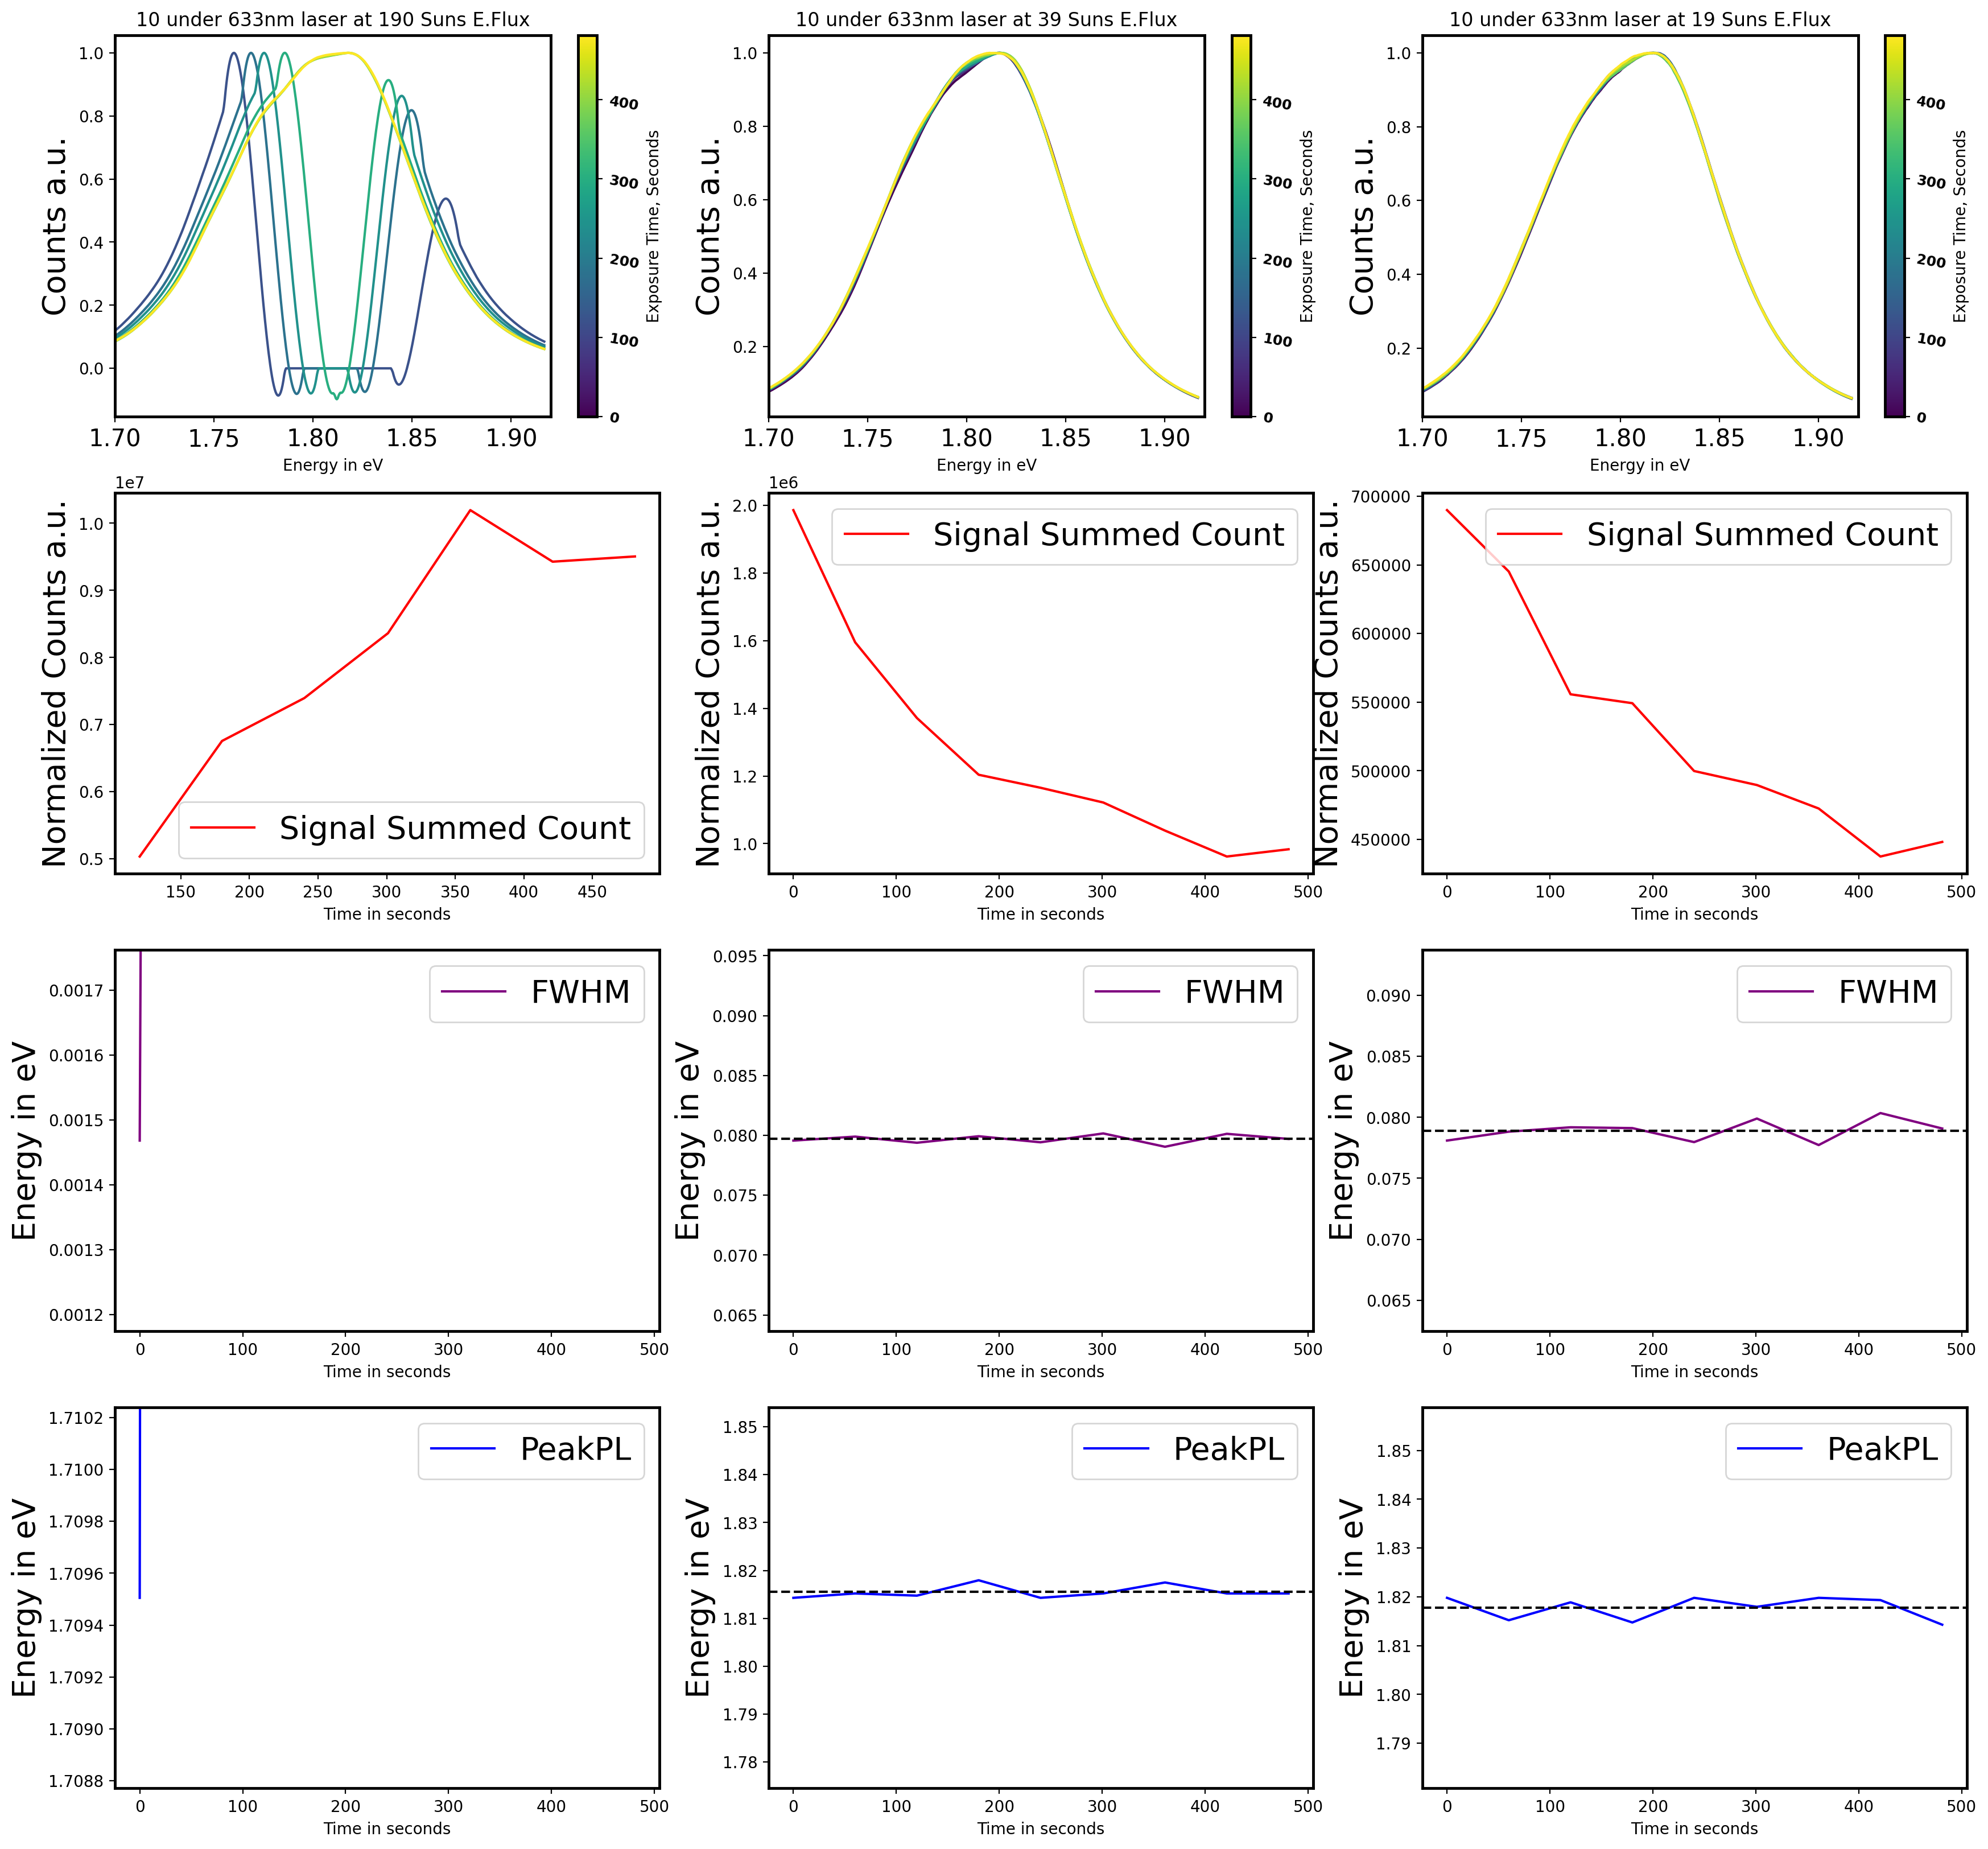

In [273]:
data = df_filter3

mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally

colors = plt.cm.viridis(np.linspace(0,1,9))

signal_slice = np.index_exp[200:700]

# sample = '10_Glass_D_p0-5'

y_value = data['tseries_smooth']

embiggen = 5
horiz = 3
vert = 4
objs = ['literallyanything' for i in range(vert*horiz)]

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))


for q in range(3):
    sample = subset_sample_list[q]

    for n in range(9):
#         ax[0,q].plot(1240/data['wl'][sample][signal_slice], y_value[sample][n][signal_slice], color = colors[n], label='Binned:'+str(np.round(np.min(data['wl'][sample][signal_slice]),2))+'nm to '+str(np.round(np.max(data['wl'][sample][signal_slice]),2))+'nm')
        ax[0,q].plot(1240/data['wl'][sample][signal_slice], y_value[sample][n][signal_slice]/(np.max(y_value[sample][n][signal_slice])), color = colors[n], label='Binned:'+str(np.round(np.min(data['wl'][sample][signal_slice]),2))+'nm to '+str(np.round(np.max(data['wl'][sample][signal_slice]),2))+'nm')

    ax[0,q].set_xlabel('Energy in eV')
    ax[0,q].set_ylabel('Counts a.u.', fontsize=20)
    ax[0,q].tick_params(axis='x', labelsize= 15)
#     ax[0,q].set_xticklabels(fontsize=15) 

    # plt.ylim(0, 2**16)
    ax[0,q].set_xlim(1.70, 1.92)

#     ax[0,q].set_xlim(1240/np.round(np.max(data['wl'][sample][signal_slice]),0), 1240/np.round(np.min(data['wl'][sample][signal_slice]),0))
    ax[0,q].set_title(str(data['Chlorine_Loading'][sample])+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')

    # plt.legend()

    norm = mpl.colors.Normalize(vmin=0, vmax=481)


    objs[0]= plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.get_cmap('viridis')),
                  orientation='vertical', label='Exposure Time, Seconds', ax=ax[0,q])

    plt.setp(objs[0].ax.get_yticklabels(),rotation=-10, fontsize=9, weight='black', snap=True, position=(1,0))


    # plt.show()


    ### Summed Count Normalized 
    # embiggen = 5
    # horiz = 1
    # vert = 1
    # objs = ['literallyanything' for i in range(vert*horiz)]

    # fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))


    binsignal = np.sum(y_value[sample][:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1) 

    binsignal_norm = binsignal#/np.max(binsignal)


    ax[1,q].plot(data['time'][sample], binsignal_norm,  label = 'Signal Summed Count', color ='red')

    ax[1,q].legend(fontsize=20)
    ax[1,q].set_xlabel('Time in seconds')
    ax[1,q].set_ylabel('Normalized Counts a.u.', fontsize=20)
    # plt.ylim(.9,1.1)
    # plt.xlim(0,150)
#     ax[1,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')


    # plt.show()


    ## FWHM Calculation
    # embiggen = 5
    # horiz = 1
    # vert = 1
    # objs = ['literallyanything' for i in range(vert*horiz)]

    # fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))
  
    centroid = np.zeros(y_value[sample].shape[0])
    peakPLWL = np.zeros(y_value[sample].shape[0])
    peakPL_count = np.zeros(y_value[sample].shape[0])
    fwhm = np.zeros(y_value[sample].shape[0])
    half_max = np.zeros(y_value[sample].shape[0])
    fwhm_ev = fwhm
    fwhm_nm = fwhm

    for n in range (0, y_value[sample].shape[0]):
        x = data['counts'][sample][n]
        peaks, _ = find_peaks(x)
        results_half = peak_widths(x, peaks, rel_height=0.5)
        
        index_width = results_half[0][np.argmax(results_half[0])]
        half_max[n] = results_half[1][np.argmax(results_half[0])]
        left_index = results_half[2][np.argmax(results_half[0])]
        right_index = results_half[3][np.argmax(results_half[0])]
                
        centroid_index = int(((left_index + right_index) /2))
        centroid[n] = data['wl'][sample][centroid_index]
        
        peakPLWL_index = np.argmax(x)
        
        peakPL_count[n] = np.max(x)

        
        peakPLWL[n] = data['wl'][sample][peakPLWL_index]
        
        fwhm_ev[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

        fwhm_nm[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

    ax[2,q].plot(data['time'][sample], fwhm_ev,  label = 'FWHM', color ='purple')
    ax[2,q].axhline(y=np.mean(fwhm_ev), color='black', linestyle='--')
    ax[2,q].set_ylim(fwhm_ev[0]-fwhm_ev[0]/5,  fwhm_ev[0]+fwhm_ev[0]/5)

    ax[2,q].legend(fontsize=20)
    ax[2,q].set_ylabel('Energy in eV', fontsize=20)
    ax[2,q].set_xlabel('Time in seconds')
#     ax[2,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')
    
    
    
#     ax[3,q].plot(data['time'][sample], centroid, label = 'Centroid', color ='blue')
#     ax[3,q].set_ylabel('nm')
#     ax[3,q].set_xlabel('Time in seconds')
#     ax[3,q].set_ylim(660, 740)
    
#     ax[3,q].legend()
    
#     ax[3,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')    

    ax[3,q].plot(data['time'][sample], 1240/peakPLWL, label = 'PeakPL', color ='blue')
    ax[3,q].set_ylabel('Energy in eV', fontsize=20)
    ax[3,q].set_xlabel('Time in seconds')
    ax[3,q].axhline(y=np.mean(1240/peakPLWL), color='black', linestyle='--')

#     ax[3,q].set_ylim(660, 740)
    ax[3,q].set_ylim(1240/peakPLWL[0]-fwhm_ev[0]/2, 1240/peakPLWL[0]+fwhm_ev[0]/2)

    ax[3,q].legend(fontsize=20)
    
#     ax[3,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')   

# ax[0,0].set_xlabel(df_XRF['sample'][n], rotation=0)


# plt.show()
    
plt.show()

In [249]:
signal_slice = np.index_exp[200:700]


In [250]:
data = df_filter3

data['binsignal'] = ''
data['peakPLWL'] = ''
data['peakPL_count'] = ''
# data['half_max'] = ''
data['fwhm_ev'] = ''
data['fwhm_nm'] = ''
data['centroid'] = ''

y_value = data['counts']

for n in range(data.shape[0]):
    data['centroid'][n]  = np.zeros(y_value[0].shape)
    data['peakPLWL'][n] = np.zeros(y_value[0].shape[0])
    data['peakPL_count'][n] = np.zeros(y_value[0].shape[0])
#     data['half_max'][n] = np.zeros(y_value[0].shape[0])
    data['fwhm_nm'][n] = np.zeros(y_value[0].shape[0])
    data['fwhm_ev'][n] = np.zeros(y_value[0].shape[0])
    

    

#gives the sum in the indexed slices
for n in range(data.shape[0]):
    data['binsignal'][n] = np.round(np.nansum(y_value[n][:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1),4)#[:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1) 

    for q in range(y_value[0].shape[0]):
        x = data['counts'][n][q]
        peaks, _ = find_peaks(x)
        results_half = peak_widths(x, peaks, rel_height=0.5)

        index_width = results_half[0][np.argmax(results_half[0])]
#         half_max = results_half[1][np.argmax(results_half[0])]
        left_index = results_half[2][np.argmax(results_half[0])]
        right_index = results_half[3][np.argmax(results_half[0])]
        centroid_index = int(((left_index + right_index) /2))
        
        
        data['centroid'][n][q] = data['wl'][n][centroid_index]

        peakPLWL_index = np.argmax(x)

        data['peakPL_count'][n][q] = np.max(x)


        data['peakPLWL'][n][q] = data['wl'][n][peakPLWL_index]

        data['fwhm_ev'][n][q] = 1*(1240/data['wl'][n][1] - 1240/data['wl'][n][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

        data['fwhm_nm'][n][q] = 1*(data['wl'][n][0] - data['wl'][n][1]) * index_width
    

In [251]:
data

,wl,time,counts,name,Chlorine_Loading,Energy_Flux,counts_despiked,tseries_avg,tseries_avg_smooth,tseries_smooth,binsignal,peakPLWL,peakPL_count,fwhm_ev,fwhm_nm,centroid
11_Glass_D_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[80.940147, 93.720169, 85.163002, 85.977112, ...",11_Glass_D_p1,0,39 Suns,"[[80.940147, 93.720169, 85.163002, 85.977112, ...","[83.36924307407406, 86.90415966666666, 85.2576...","[85.36887235614617, 85.15458086736558, 84.9450...","[[84.52359463337342, 84.63116930985983, 84.717...","[120058.7892, 122168.2877, 122135.3151, 122011...","[673.814514, 671.919006, 674.503845, 673.29754...","[539.606689, 539.861328, 536.085815, 538.12408...","[0.06068836050775412, 0.0614702578133476, 0.06...","[28.820819841050245, 29.192141807736643, 29.45...","[[675.53772, 675.53772, 675.53772, 675.53772, ..."
08_Glass_C_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[104.796196, 102.240189, 98.789085, 90.233398...",08_Glass_C_p1,1,39 Suns,"[[104.796196, 102.240189, 98.789085, 90.233398...","[93.72017166666667, 90.88016688888888, 91.2190...","[92.65873652424295, 92.43002057751742, 92.2110...","[[102.95417020180064, 102.75418128250625, 102....","[85546.7747, 59777.8584, 51036.3824, 46504.673...","[677.4332889999998, 673.642212, 671.574341, 67...","[311.655182, 208.093796, 174.097488, 152.31074...","[0.07213346650599305, 0.06752313273331914, 0.0...","[34.2560851090059, 32.066643872537384, 30.8860...","[[679.673584, 679.673584, 679.673584, 679.6735..."
02_Glass_B_p1,"[757.4482419999999, 757.275391, 757.1025999999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[65.55307, 75.510498, 64.694687, 75.443779, 6...",02_Glass_B_p1,5,39 Suns,"[[65.55307, 75.510498, 64.694687, 75.443779, 6...","[101.16347464444445, 92.85616242222223, 82.384...","[83.03333875912575, 81.63343452962137, 80.3038...","[[69.52400202251644, 69.54682572304169, 69.566...","[523186.2259, 481469.6684, 461674.6215, 448472...","[667.064575, 667.926208, 668.0985109999999, 66...","[2477.663574, 2276.874268, 2198.374023, 2128.7...","[0.06008683937436556, 0.05957044608126019, 0.0...","[27.79485936651922, 27.55598710914765, 27.2552...","[[669.649414, 669.649414, 669.649414, 669.6494..."
05_Glass_A_p1,"[767.467896, 767.2950439999998, 767.1222529999...","[0.0, 60.0, 120.0, 180.0, 240.0, 301.0, 361.0,...","[[109.908203, 107.352196, 110.711906, 104.7047...",05_Glass_A_p1,10,39 Suns,"[[109.908203, 107.352196, 110.711906, 104.7047...","[101.57751966666667, 101.00951977777778, 104.3...","[103.94518566596356, 103.74568226616115, 103.5...","[[109.15754761285162, 108.85101860879828, 108....","[1986366.9631, 1595576.0895, 1371559.0804, 120...","[683.4650269999998, 683.1202999999999, 683.292...","[8268.383789, 6624.858398, 5760.371582, 4994.8...","[0.07956636616699285, 0.07989751927917481, 0.0...","[37.785959045852614, 37.943223208307295, 37.69...","[[687.4288939999999, 687.4288939999999, 687.42..."


In [252]:
data.columns

Index(['wl', 'time', 'counts', 'name', 'Chlorine_Loading', 'Energy_Flux',
       'counts_despiked', 'tseries_avg', 'tseries_avg_smooth',
       'tseries_smooth', 'binsignal', 'peakPLWL', 'peakPL_count', 'fwhm_ev',
       'fwhm_nm', 'centroid'],
      dtype='object')

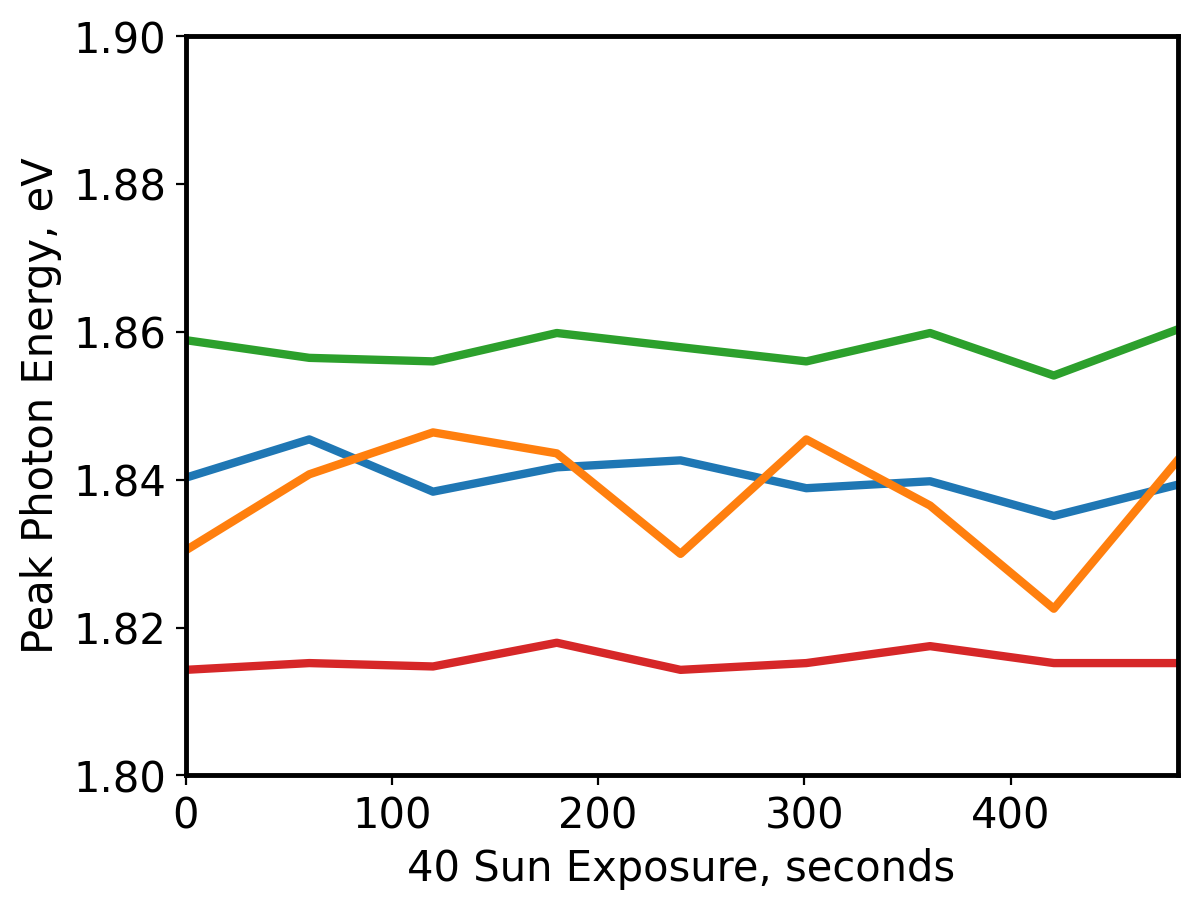

In [263]:
for n in range(data.shape[0]):
    plt.plot(data['time'][n], 1240/data['peakPLWL'][n], label=(str(data['Chlorine_Loading'][n])+'% Chlorine'), linewidth=3)

plt.ylabel('Peak Photon Energy, eV', size=15)
plt.xlabel('40 Sun Exposure, seconds', size=15)
plt.xlim(data['time'][n][0],data['time'][n][-1])

plt.ylim(1.8,1.9)
plt.xticks(size=15)
plt.yticks(size=15)

# plt.legend()
plt.show()

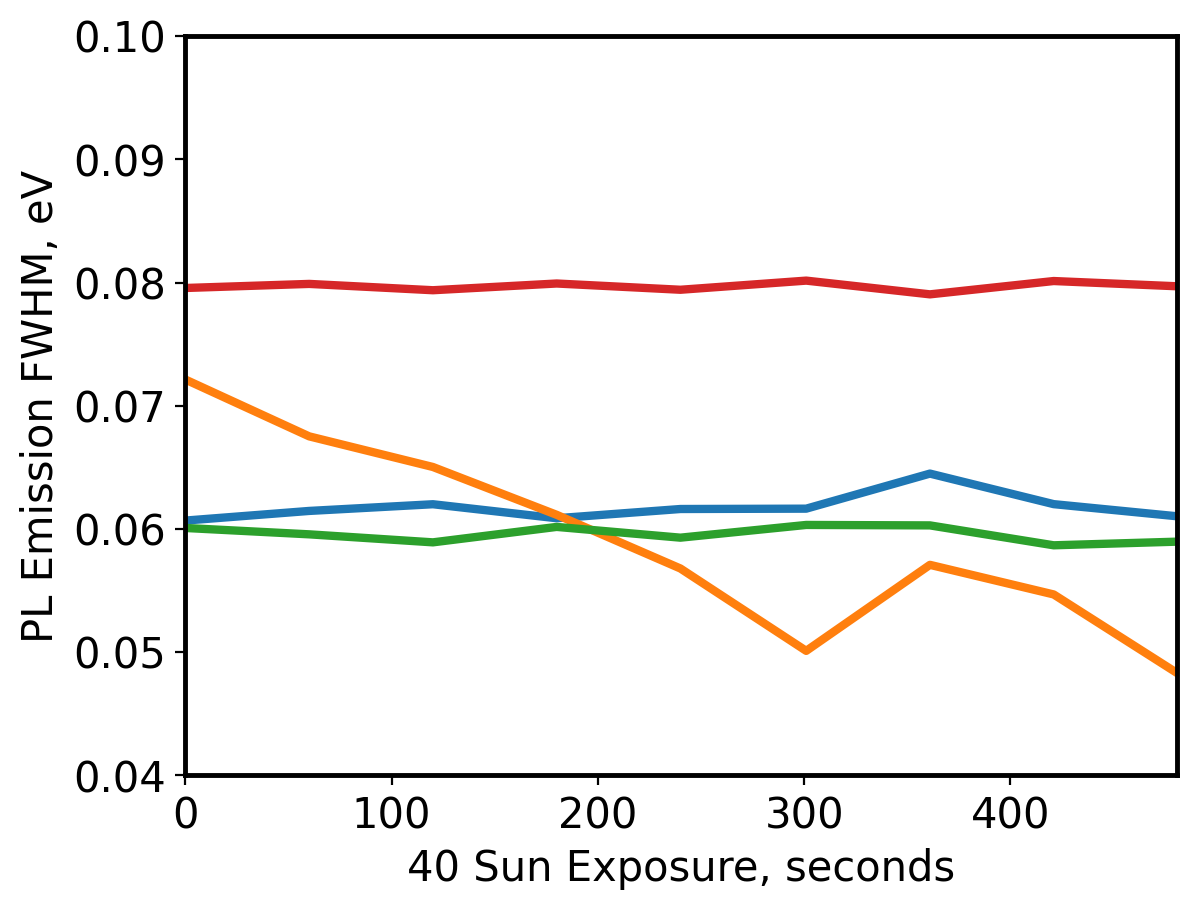

In [265]:
for n in range(data.shape[0]):
    plt.plot(data['time'][n], data['fwhm_ev'][n], label=data['Chlorine_Loading'][n], linewidth=3)

plt.ylabel('PL Emission FWHM, eV', size=15)
plt.xlabel('40 Sun Exposure, seconds', size=15)
plt.xlim(data['time'][n][0],data['time'][n][-1])

plt.ylim(.04,.1)
plt.xticks(size=15)
plt.yticks(size=15)

# plt.legend()
plt.show()

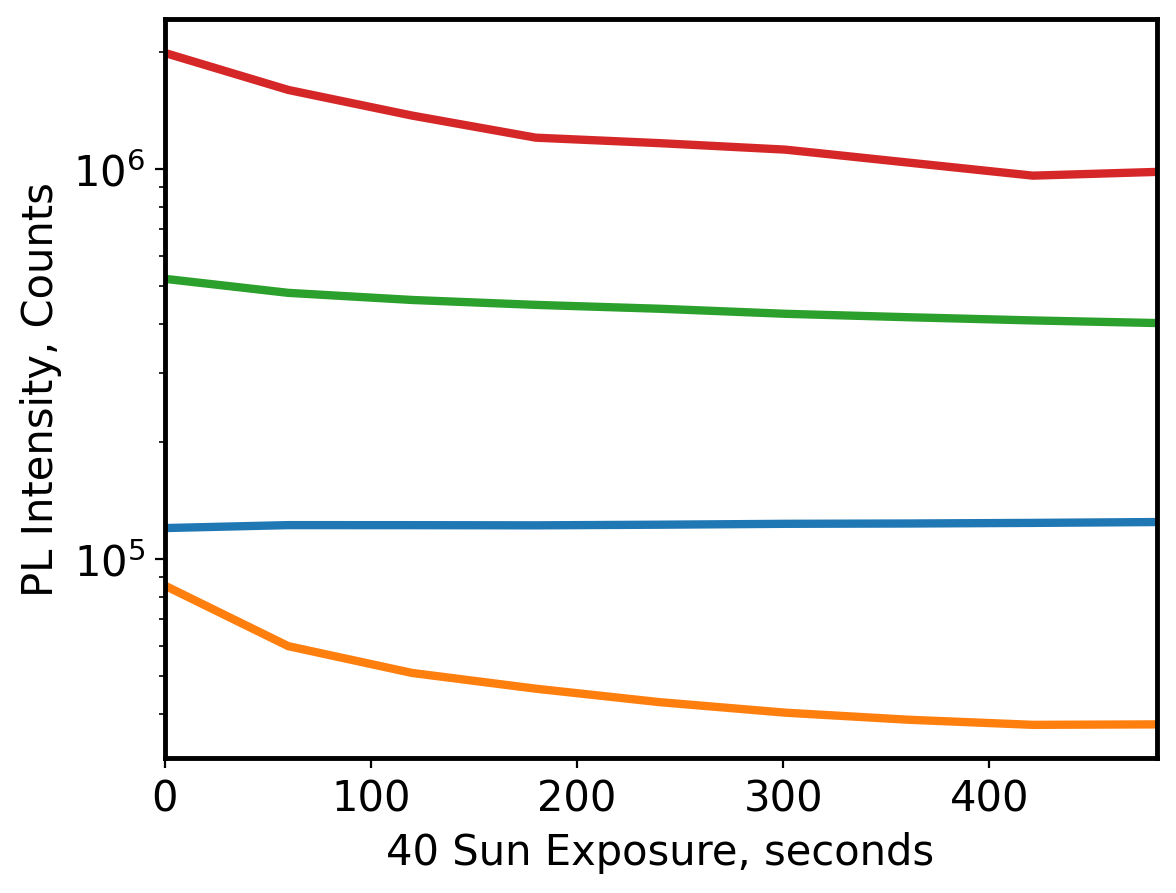

In [268]:
for n in range(data.shape[0]):
    plt.semilogy(data['time'][n], data['binsignal'][n], label=data['Chlorine_Loading'][n], linewidth=3)

plt.ylabel('PL Intensity, Counts', size=15)
plt.xlabel('40 Sun Exposure, seconds', size=15)

plt.xlim(data['time'][n][0],data['time'][n][-1])
plt.xticks(size=15)
plt.yticks(size=15)

# plt.legend()
plt.show()

In [ ]:
plt.plot()

In [130]:
data['wl'][n][centroid_index]

687.773621

In [65]:
data['counts'][0].shape[0]

9

In [61]:
df_filter3['binsignal'][0]

array([   61908.5645,  3481468.2791,  5108026.76  ,  6790666.8359,
        7399057.2644,  8364752.1394, 10195410.3686,  9427256.1956,
        9505185.6565])

In [663]:



df_filter3['binsignal'] = np.sum(y_value[:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1) 


# binsignal = np.sum(y_value[sample][:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1) 

binsignal_norm = binsignal#/np.max(binsignal)

centroid = np.zeros(y_value[sample].shape[0])
peakPLWL = np.zeros(y_value[sample].shape[0])
peakPL_count = np.zeros(y_value[sample].shape[0])
fwhm = np.zeros(y_value[sample].shape[0])
half_max = np.zeros(y_value[sample].shape[0])
fwhm_ev = fwhm
fwhm_nm = fwhm

for n in range (0, y_value[sample].shape[0]):
    x = data['counts'][sample][n]
    peaks, _ = find_peaks(x)
    results_half = peak_widths(x, peaks, rel_height=0.5)

    index_width = results_half[0][np.argmax(results_half[0])]
    half_max[n] = results_half[1][np.argmax(results_half[0])]
    left_index = results_half[2][np.argmax(results_half[0])]
    right_index = results_half[3][np.argmax(results_half[0])]

    centroid_index = int(((left_index + right_index) /2))
    centroid[n] = data['wl'][sample][centroid_index]

    peakPLWL_index = np.argmax(x)

    peakPL_count[n] = np.max(x)


    peakPLWL[n] = data['wl'][sample][peakPLWL_index]

    fwhm_ev[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

    fwhm_nm[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width

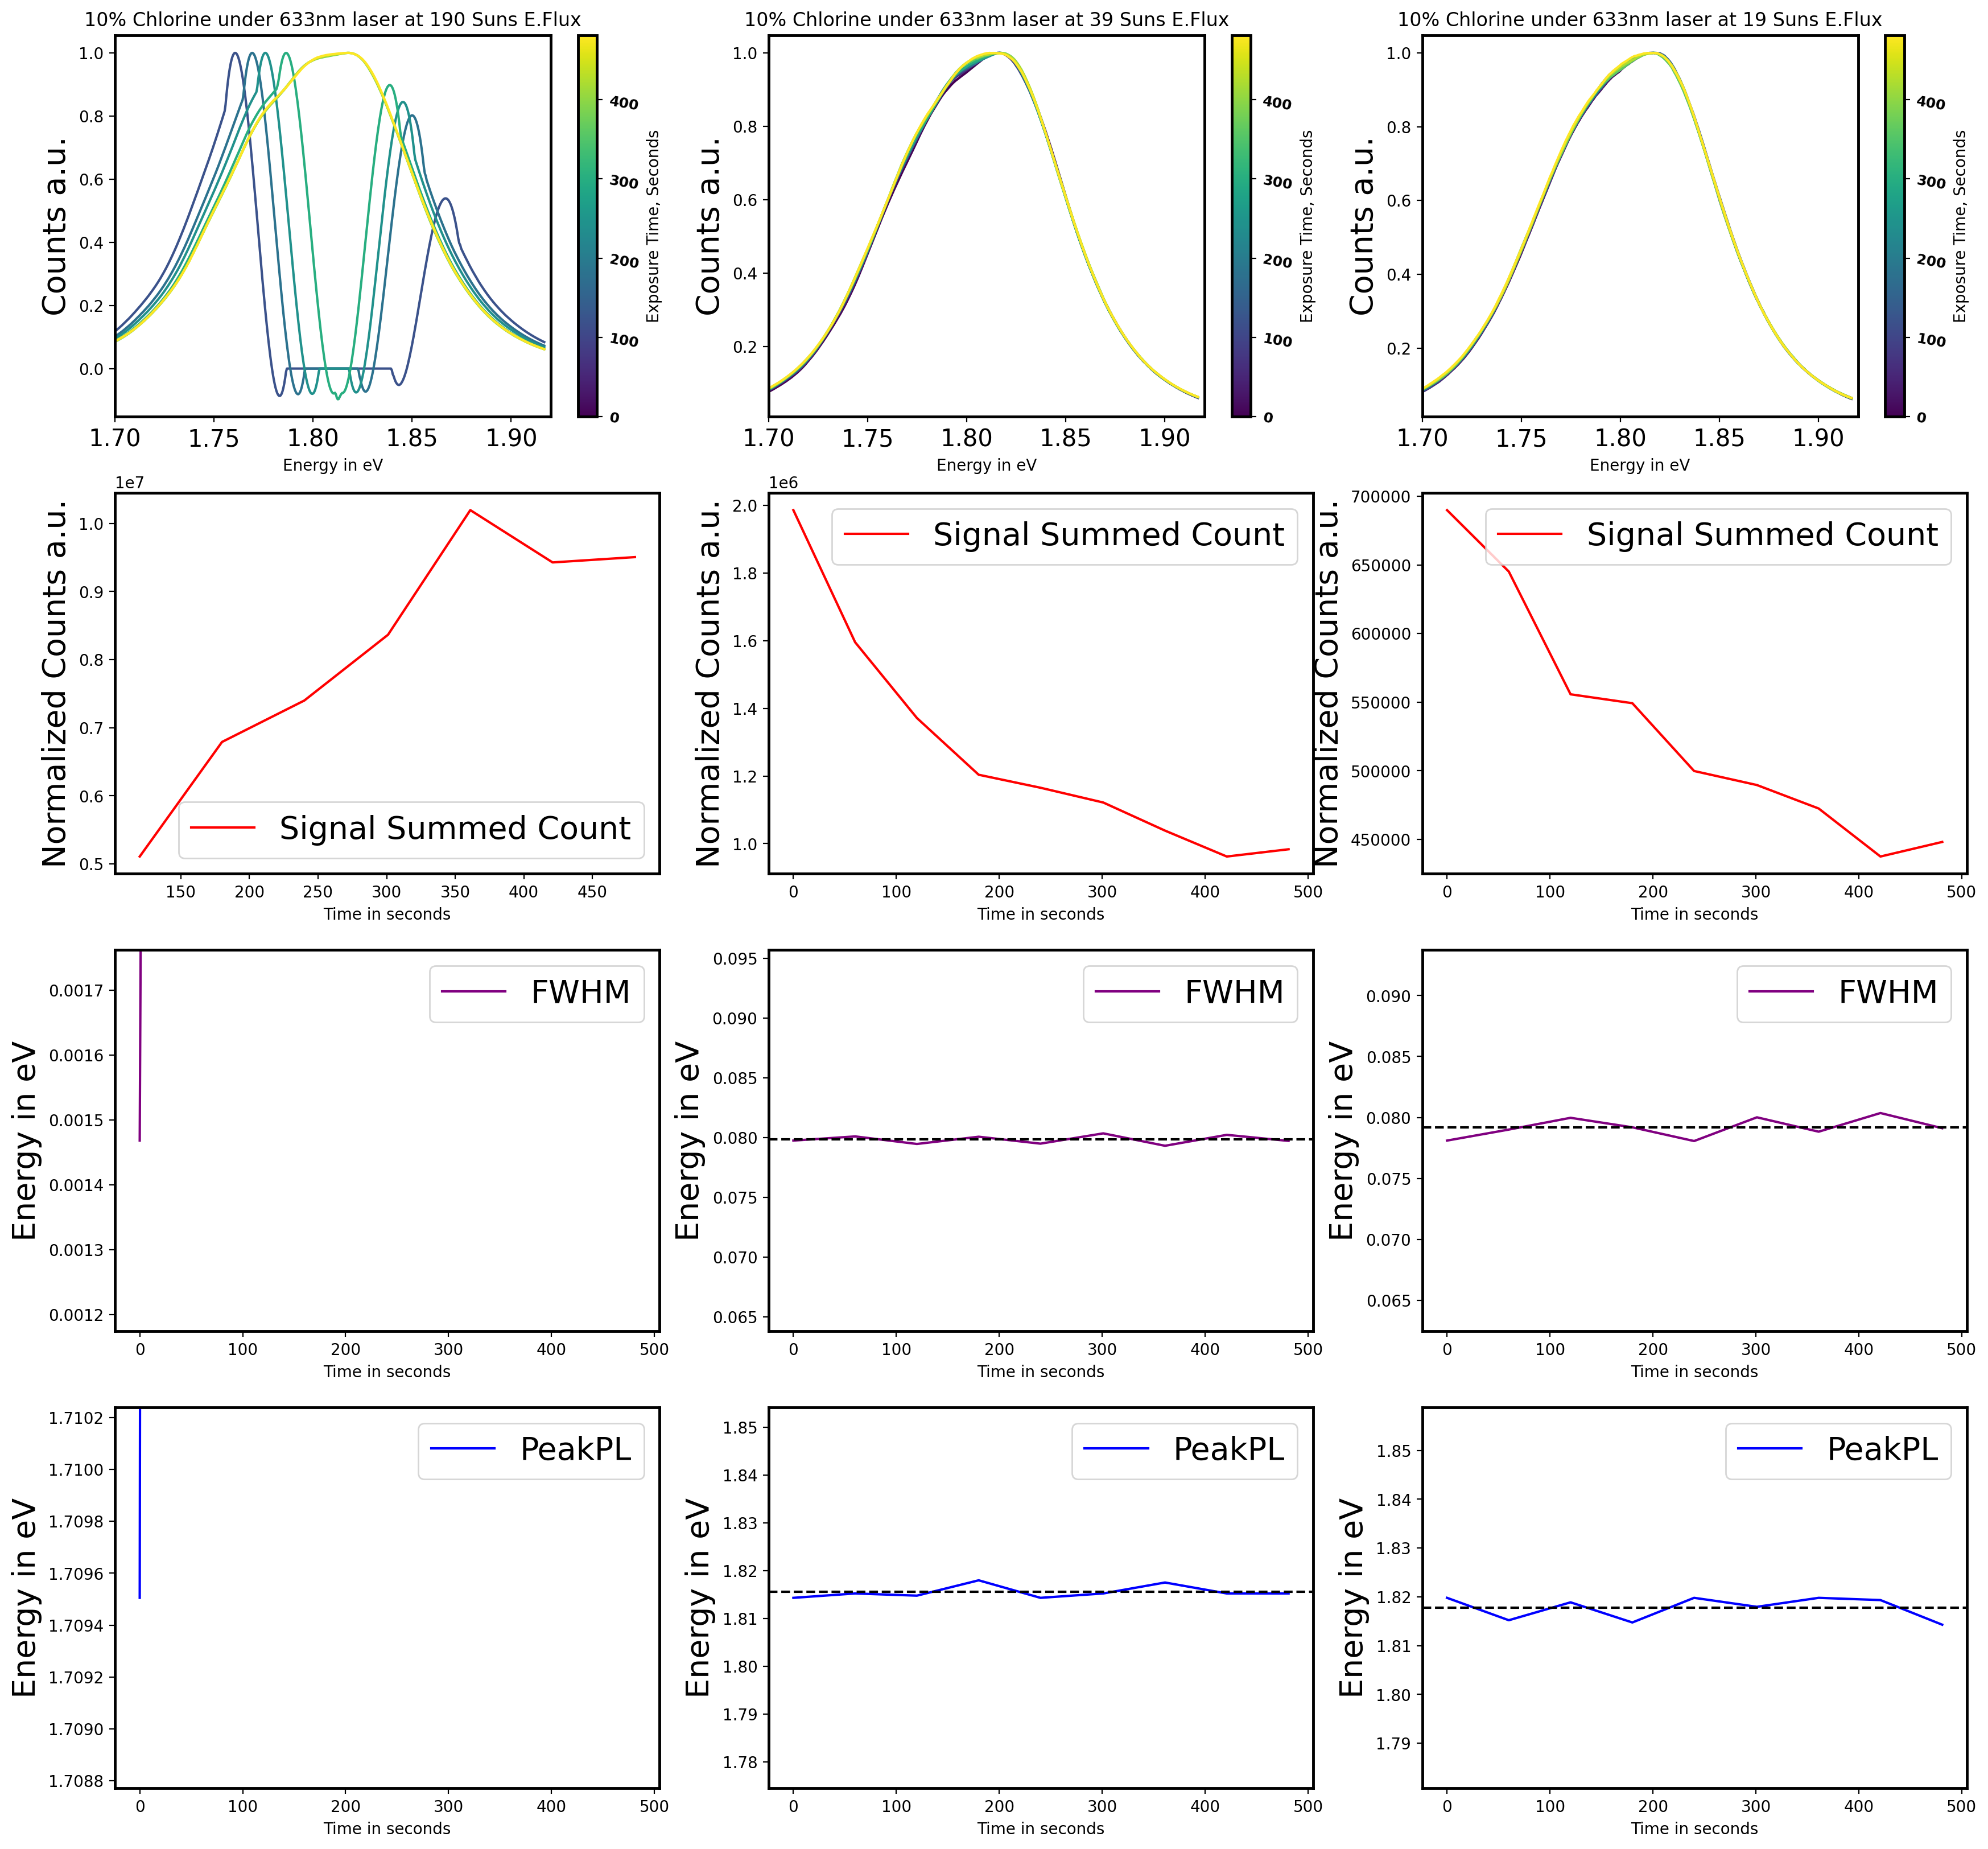

In [59]:
data = df_filter3

mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally

colors = plt.cm.viridis(np.linspace(0,1,9))

signal_slice = np.index_exp[200:700]

# sample = '10_Glass_D_p0-5'

y_value = data['tseries_smooth']

embiggen = 5
horiz = 3
vert = 4
objs = ['literallyanything' for i in range(vert*horiz)]

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))


for q in range(3):
    sample = subset_sample_list[q]

    for n in range(9):
#         ax[0,q].plot(1240/data['wl'][sample][signal_slice], y_value[sample][n][signal_slice], color = colors[n], label='Binned:'+str(np.round(np.min(data['wl'][sample][signal_slice]),2))+'nm to '+str(np.round(np.max(data['wl'][sample][signal_slice]),2))+'nm')
        ax[0,q].plot(1240/data['wl'][sample][signal_slice], y_value[sample][n][signal_slice]/(np.max(y_value[sample][n][signal_slice])), color = colors[n], label='Binned:'+str(np.round(np.min(data['wl'][sample][signal_slice]),2))+'nm to '+str(np.round(np.max(data['wl'][sample][signal_slice]),2))+'nm')

    ax[0,q].set_xlabel('Energy in eV')
    ax[0,q].set_ylabel('Counts a.u.', fontsize=20)
    ax[0,q].tick_params(axis='x', labelsize= 15)
#     ax[0,q].set_xticklabels(fontsize=15) 

    # plt.ylim(0, 2**16)
    ax[0,q].set_xlim(1.70, 1.92)

#     ax[0,q].set_xlim(1240/np.round(np.max(data['wl'][sample][signal_slice]),0), 1240/np.round(np.min(data['wl'][sample][signal_slice]),0))
    ax[0,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')

    # plt.legend()

    norm = mpl.colors.Normalize(vmin=0, vmax=481)


    objs[0]= plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.get_cmap('viridis')),
                  orientation='vertical', label='Exposure Time, Seconds', ax=ax[0,q])

    plt.setp(objs[0].ax.get_yticklabels(),rotation=-10, fontsize=9, weight='black', snap=True, position=(1,0))


    # plt.show()


    ### Summed Count Normalized 
    # embiggen = 5
    # horiz = 1
    # vert = 1
    # objs = ['literallyanything' for i in range(vert*horiz)]

    # fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))


    binsignal = np.sum(y_value[sample][:, int(str(signal_slice).split('e(')[1].split(",")[0]):int(str(signal_slice).split('e(')[1].split(",")[1][1:])], axis = 1) 

    binsignal_norm = binsignal#/np.max(binsignal)


    ax[1,q].plot(data['time'][sample], binsignal_norm,  label = 'Signal Summed Count', color ='red')

    ax[1,q].legend(fontsize=20)
    ax[1,q].set_xlabel('Time in seconds')
    ax[1,q].set_ylabel('Normalized Counts a.u.', fontsize=20)
    # plt.ylim(.9,1.1)
    # plt.xlim(0,150)
#     ax[1,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')


    # plt.show()


    ## FWHM Calculation
    # embiggen = 5
    # horiz = 1
    # vert = 1
    # objs = ['literallyanything' for i in range(vert*horiz)]

    # fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))
  
    centroid = np.zeros(y_value[sample].shape[0])
    peakPLWL = np.zeros(y_value[sample].shape[0])
    peakPL_count = np.zeros(y_value[sample].shape[0])
    fwhm = np.zeros(y_value[sample].shape[0])
    half_max = np.zeros(y_value[sample].shape[0])
    fwhm_ev = fwhm
    fwhm_nm = fwhm

    for n in range (0, y_value[sample].shape[0]):
        x = data['counts'][sample][n]
        peaks, _ = find_peaks(x)
        results_half = peak_widths(x, peaks, rel_height=0.5)
        
        index_width = results_half[0][np.argmax(results_half[0])]
        half_max[n] = results_half[1][np.argmax(results_half[0])]
        left_index = results_half[2][np.argmax(results_half[0])]
        right_index = results_half[3][np.argmax(results_half[0])]
                
        centroid_index = int(((left_index + right_index) /2))
        centroid[n] = data['wl'][sample][centroid_index]
        
        peakPLWL_index = np.argmax(x)
        
        peakPL_count[n] = np.max(x)

        
        peakPLWL[n] = data['wl'][sample][peakPLWL_index]
        
        fwhm_ev[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

        fwhm_nm[n] = 1*(1240/data['wl'][sample][1] - 1240/data['wl'][sample][0]) * index_width #calcualtes nm difference between two points and multiplied by index width

    ax[2,q].plot(data['time'][sample], fwhm_ev,  label = 'FWHM', color ='purple')
    ax[2,q].axhline(y=np.mean(fwhm_ev), color='black', linestyle='--')
    ax[2,q].set_ylim(fwhm_ev[0]-fwhm_ev[0]/5,  fwhm_ev[0]+fwhm_ev[0]/5)

    ax[2,q].legend(fontsize=20)
    ax[2,q].set_ylabel('Energy in eV', fontsize=20)
    ax[2,q].set_xlabel('Time in seconds')
#     ax[2,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')
    
    
    
#     ax[3,q].plot(data['time'][sample], centroid, label = 'Centroid', color ='blue')
#     ax[3,q].set_ylabel('nm')
#     ax[3,q].set_xlabel('Time in seconds')
#     ax[3,q].set_ylim(660, 740)
    
#     ax[3,q].legend()
    
#     ax[3,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')    

    ax[3,q].plot(data['time'][sample], 1240/peakPLWL, label = 'PeakPL', color ='blue')
    ax[3,q].set_ylabel('Energy in eV', fontsize=20)
    ax[3,q].set_xlabel('Time in seconds')
    ax[3,q].axhline(y=np.mean(1240/peakPLWL), color='black', linestyle='--')

#     ax[3,q].set_ylim(660, 740)
    ax[3,q].set_ylim(1240/peakPLWL[0]-fwhm_ev[0]/2, 1240/peakPLWL[0]+fwhm_ev[0]/2)

    ax[3,q].legend(fontsize=20)
    
#     ax[3,q].set_title(data['Chlorine_Loading'][sample]+' under 633nm laser at '+data['Energy_Flux'][sample]+' E.Flux')   

# ax[0,0].set_xlabel(df_XRF['sample'][n], rotation=0)


# plt.show()
    
plt.show()

## Trying to fit curves with multipeaks

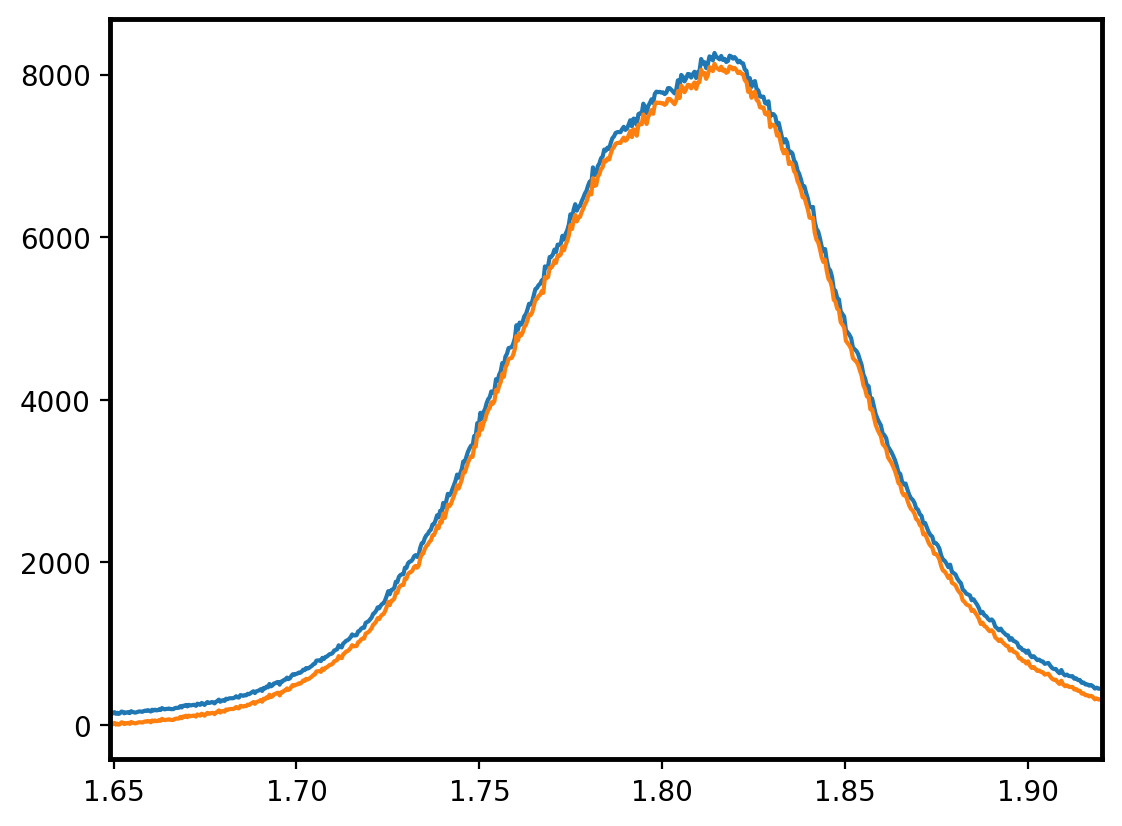

In [274]:
# del y_test

from scipy.spatial import ConvexHull

def rubberband(x, y):
    # Find the convex hull
    v = ConvexHull(np.array(list(zip(x, y)))).vertices
    # Rotate convex hull vertices until they start from the lowest one
    v = np.roll(v, -v.argmin())
    # Leave only the ascending part
    v = v[:v.argmax()]

    # Create baseline using linear interpolation between vertices
    return np.interp(x, x[v], y[v])

left_cutoff = 90
index = 1
x_test = 1240/data['wl'][index][left_cutoff:]
y_test = data['counts_despiked'][index][0][left_cutoff:]


plt.plot(x_test, y_test)

plt.xlim(x_test[0],x_test[-1])


bg=rubberband(x_test, y_test)

y_test_bg = y_test - bg

y_test_bg[y_test_bg<0] = 0

plt.plot(x_test, y_test_bg)

# y_test = y_test_bg

plt.show()





## Attempts at building a peak count agnostic model

In [275]:
x_test.shape

(617,)

In [276]:
y_test.shape

(617,)

In [277]:
# X,Y = x_test, y_test 

In [278]:
X_test,Y_test = x_test, y_test 

In [279]:
Y_test.shape[0]

617

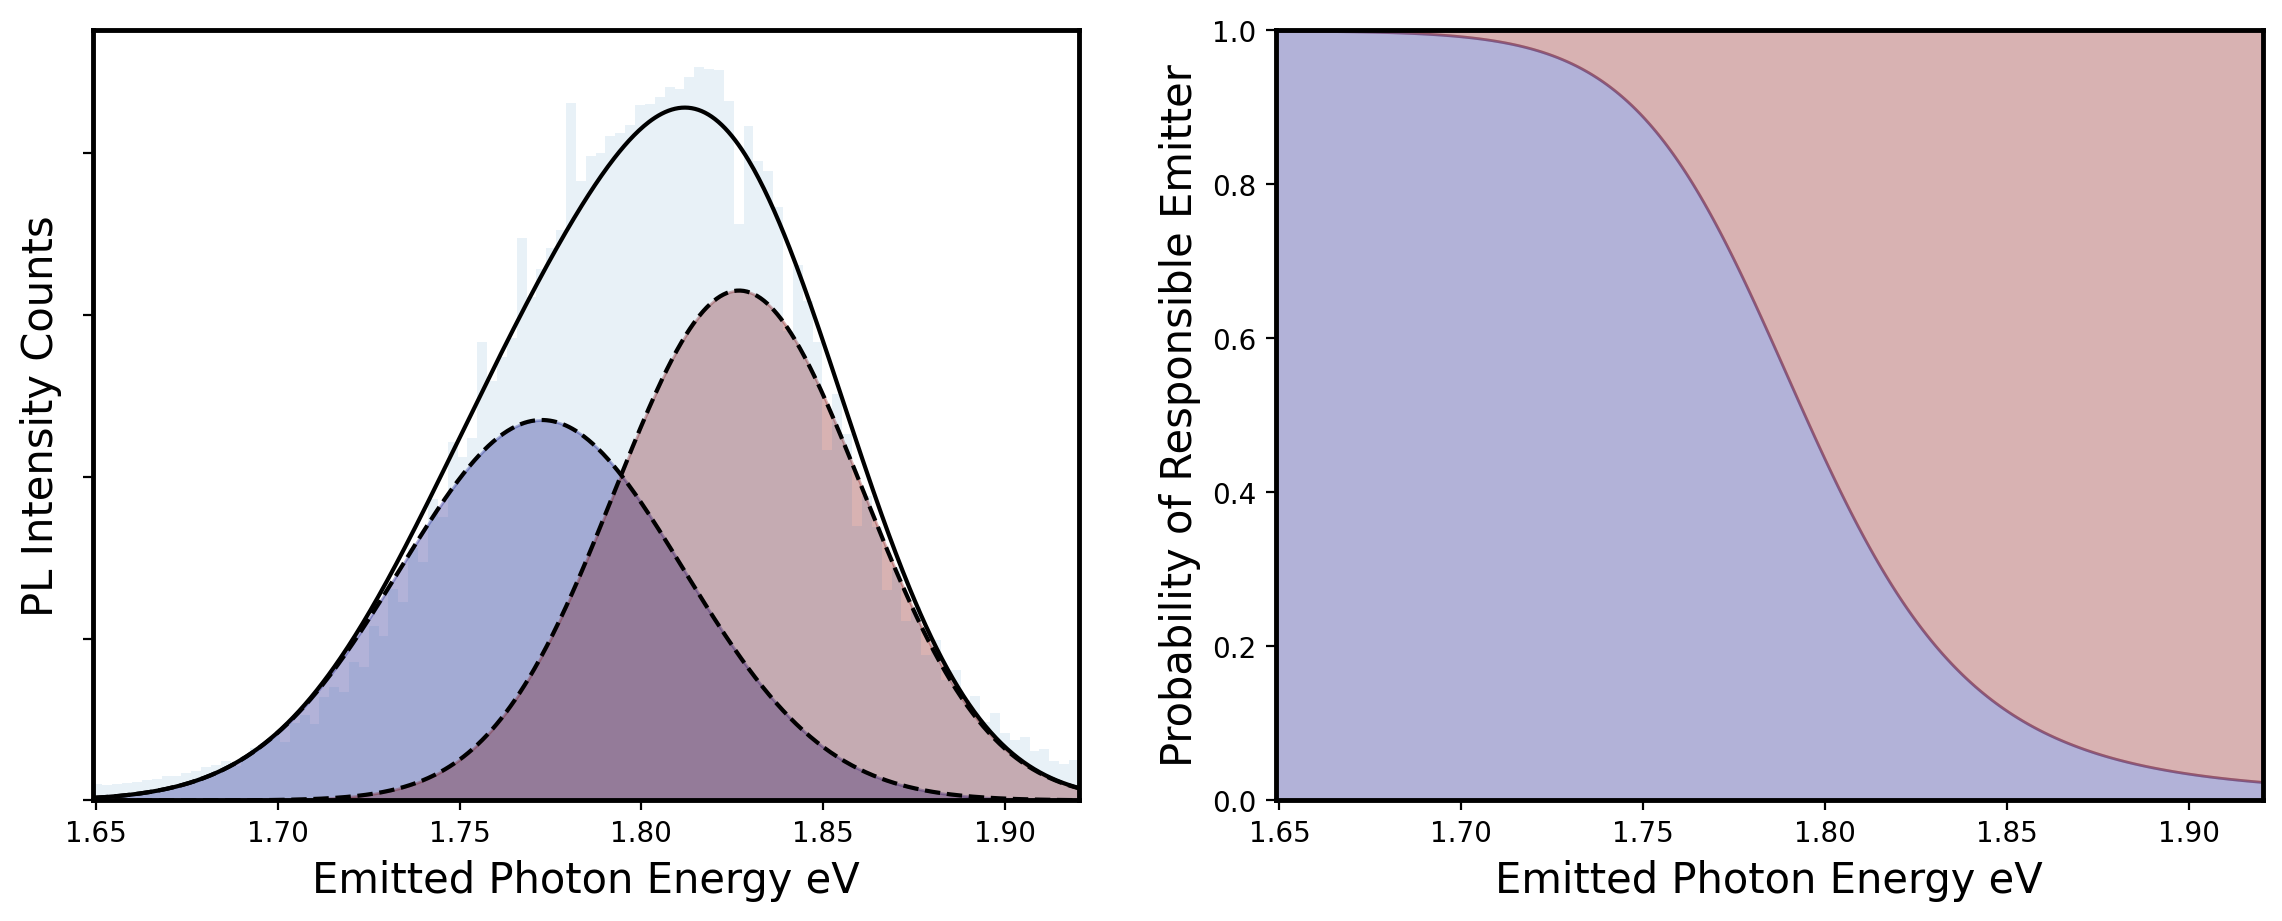

In [283]:
from numpy.random import choice
from scipy.stats import skew
from sklearn.mixture import GaussianMixture


N_components = 2

draw_N = 1000000
draw = choice(X_test, draw_N,
              p=Y_test/np.sum(Y_test))
draw = draw.reshape(-1,1)

draw_mean = np.mean(draw)
draw_var = np.var(draw)
draw_skew= skew(draw)[0]
# print('draw mean: '+ str(np.round(draw_mean,5)))
# print('draw var: '+ str(np.round(draw_var,5)))
# print('draw skew: '+ str(np.round(draw_skew,5)))

# plt.hist(draw, X_test)
# plt.xlim(1.65,1.9)
# plt.show()

X = draw


#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

# X = np.concatenate([random_state.normal(-1, 1.5, 350),
#                     random_state.normal(0, 1, 500),
#                     random_state.normal(3, 0.5, 150)]).reshape(-1, 1)


#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components

N = np.arange(1, N_components+1)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

# fig = plt.figure(figsize=(5, 1.7))
# fig.subplots_adjust(left=0.12, right=0.97,
#                     bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
# ax = fig.add_subplot(1,3)
colors = plt.cm.jet(np.linspace(0,1,len(N)))

embiggen = 5
horiz = 2
vert = 1
objs = ['literallyanything' for i in range(vert*horiz)]

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))
M_best = models[np.argmin(AIC)]

# x = np.linspace(-6, 6, 1000)
# logprob = M_best.score_samples(x.reshape(-1, 1))
# responsibilities = M_best.predict_proba(x.reshape(-1, 1))

x = X_test
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))



pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax[0].hist(X, 100, density=True, histtype='stepfilled', alpha=0.1)


ax[0].plot(x, pdf, '-k')

ax[0].plot(x, pdf_individual, '--k')
for n in range(0,len(N)):
    ax[0].fill_between(x, 0, pdf_individual[:,n], alpha=0.3, color = colors[n])

    
ax[0].set_xlim(x[0],x[-1])
ax[0].set_xlabel('Emitted Photon Energy eV', size=15)
ax[0].set_ylabel('PL Intensity Counts', size=15)


# ax[0].text(0.01, .99, s = ('# Emitters : '+ str(np.round(N_components,0))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
# ax[0].text(0.01, .94, s = ('Dist. mean: '+ str(np.round(draw_mean,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
# ax[0].text(0.01, .89, s = ('Dist. var: '+ str(np.round(draw_var,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
# ax[0].text(0.01, .84, s = ('Dist. skew: '+ str(np.round(draw_skew,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
# ax[0].text(0.01, .79, s = ('Max PL Counts: '+ str(np.round(np.max(Y_test),2))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)


ax[0].set_yticklabels([])

if N_components ==10:

    # plot 2: AIC and BIC
    ax[1].plot(N, AIC, '-k', label='AIC')
    ax[1].plot(N, BIC, '--k', label='BIC')
    ax[1].set_xlabel('Number of Emitters', size=15)
    ax[1].set_ylabel('Information Criterion', size=15)
    ax[1].legend(loc=1)
    ax[1].set_yticklabels([])
    tick_spacing = 1
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
else: 
    
    # plot 3: posterior probabilities for each component
    p = responsibilities
    p = p.cumsum(1).T

    n = 0
    ax[1].fill_between(x, 0, p[0],  color = colors[n], alpha=0.3)

    for n in range(0,len(N)-2):
        ax[1].fill_between(x, p[n], p[n+1],  color = colors[n+1], alpha=0.3)

    n = len(N)-2
    ax[1].fill_between(x, p[n], 1,  color = colors[n+1], alpha=0.3)


    ax[1].set_ylim(0, 1)
    ax[1].set_xlabel('Emitted Photon Energy eV', size= 15)
    ax[1].set_ylabel('Probability of Responsible Emitter', size=15)
    ax[1].set_xlim(x[0],x[-1])


plt.show()

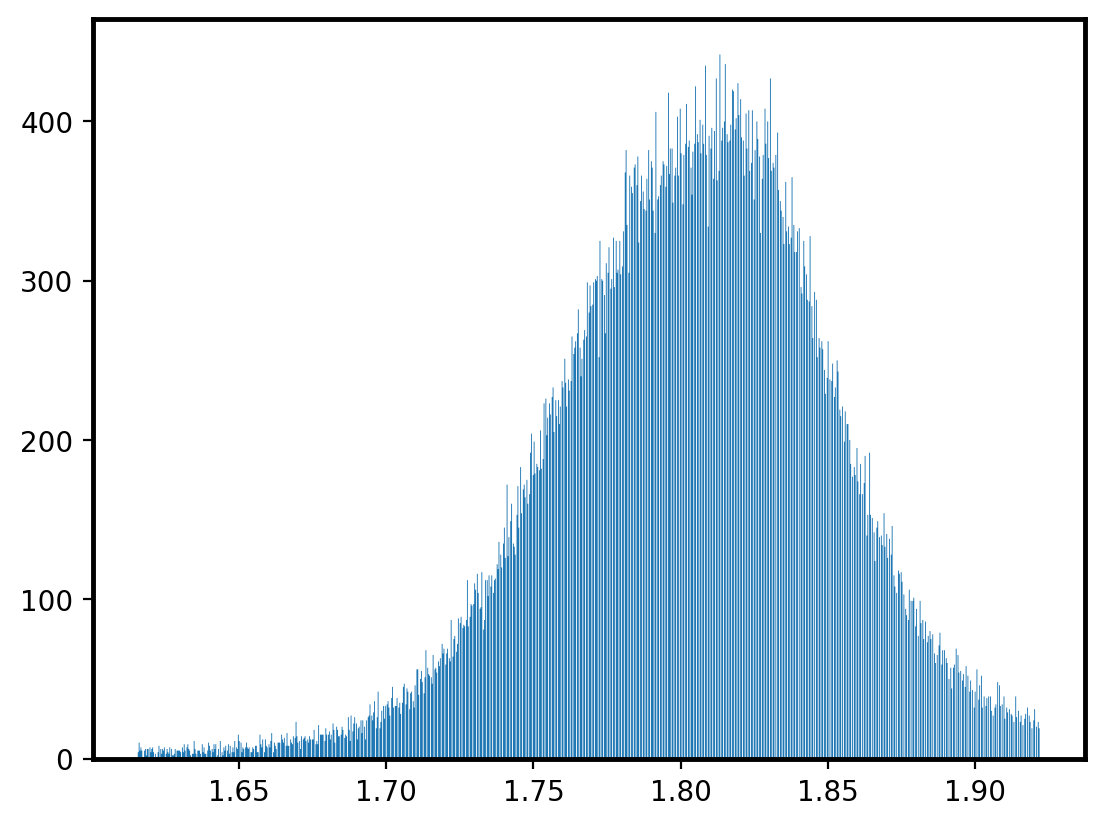

In [123]:
weights = np.ones_like(X)*np.max(Y)


plt.hist(X, 1000, density=False, histtype='stepfilled', alpha=1)#, weights = weights)
plt.show()


draw mean: 1.80099
draw var: 0.00221
draw skew: -0.38584


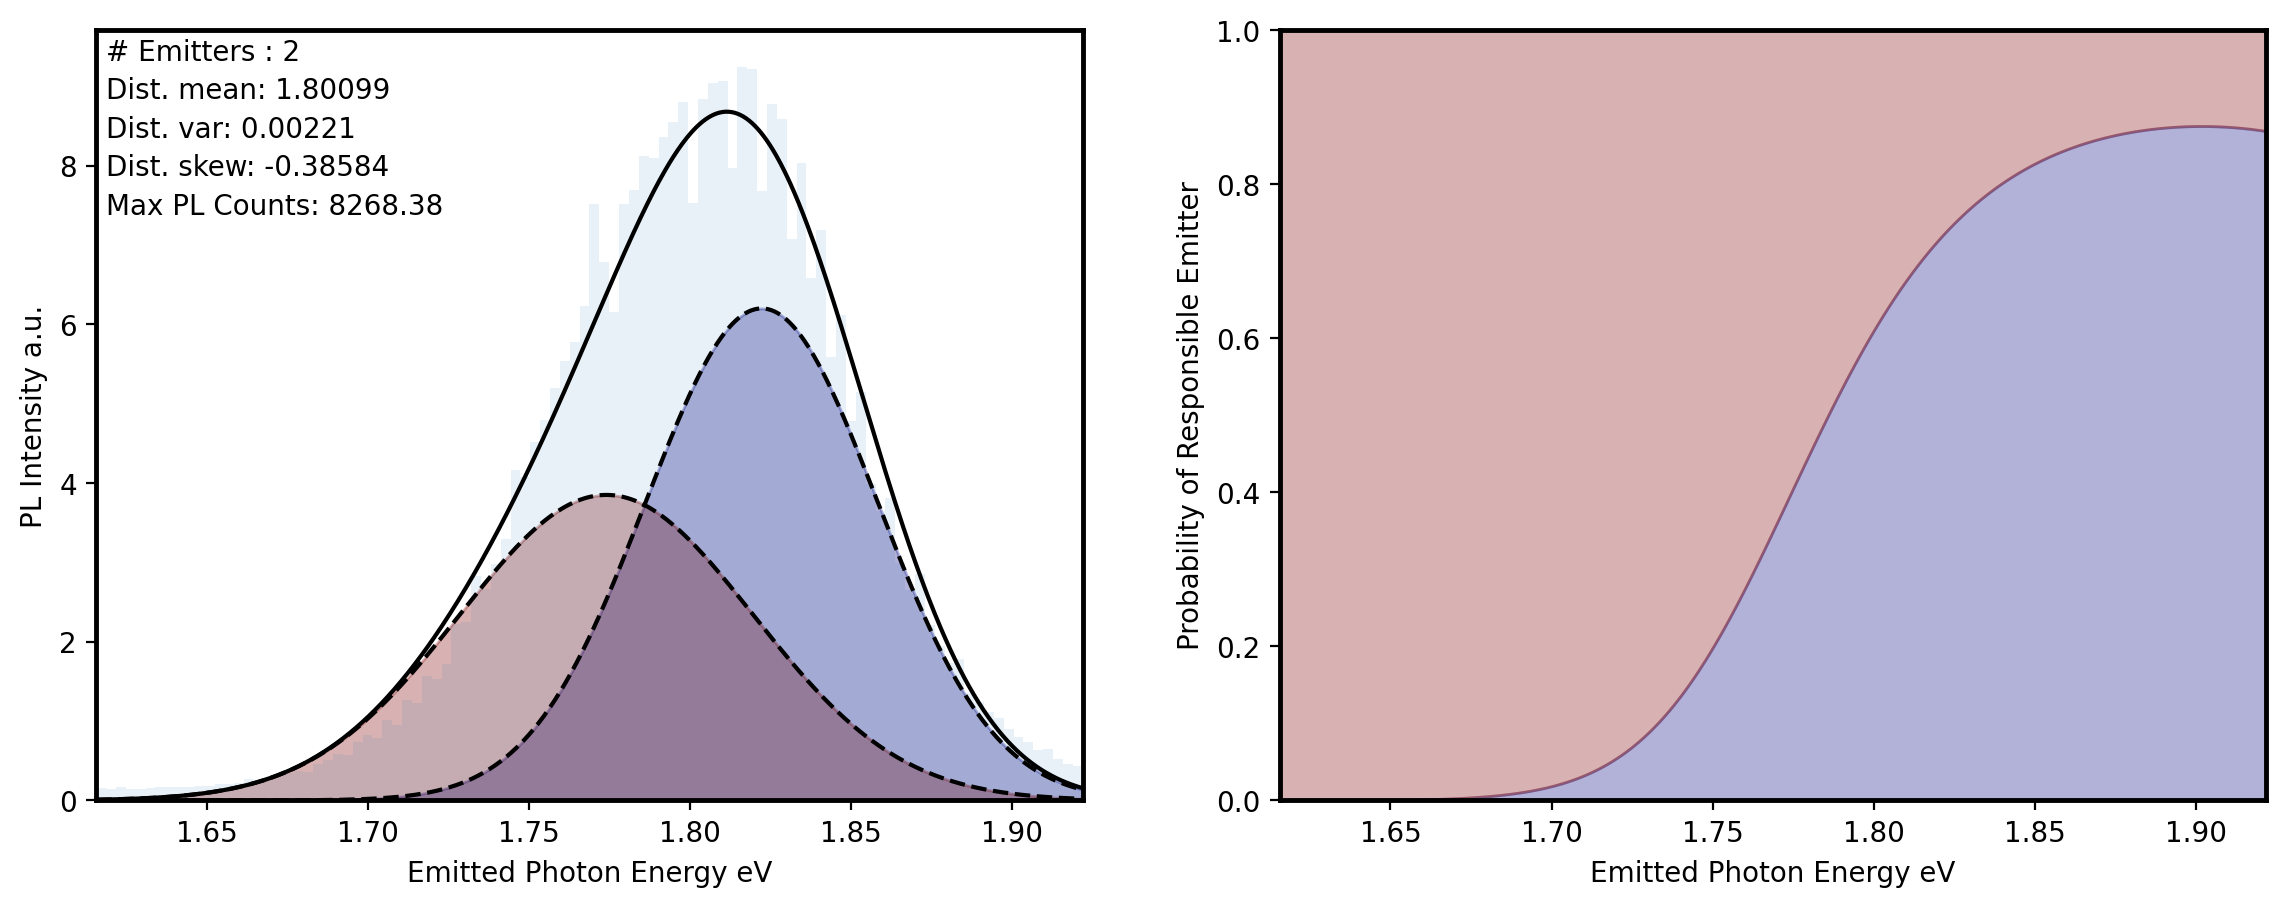

In [151]:
from numpy.random import choice
from scipy.stats import skew
from sklearn.mixture import GaussianMixture

draw_N = 1000000
draw = choice(X_test, draw_N,
              p=Y_test/np.sum(Y_test))
draw = draw.reshape(-1,1)

draw_mean = np.mean(draw)
draw_var = np.var(draw)
draw_skew= skew(draw)[0]
print('draw mean: '+ str(np.round(draw_mean,5)))
print('draw var: '+ str(np.round(draw_var,5)))
print('draw skew: '+ str(np.round(draw_skew,5)))

# plt.hist(draw, X_test)
# plt.xlim(1.65,1.9)
# plt.show()

X = draw


#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

# X = np.concatenate([random_state.normal(-1, 1.5, 350),
#                     random_state.normal(0, 1, 500),
#                     random_state.normal(3, 0.5, 150)]).reshape(-1, 1)


#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components

N_components = 2
N = np.arange(1, N_components+1)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

# fig = plt.figure(figsize=(5, 1.7))
# fig.subplots_adjust(left=0.12, right=0.97,
#                     bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
# ax = fig.add_subplot(1,3)
colors = plt.cm.jet(np.linspace(0,1,len(N)))

embiggen = 5
horiz = 2
vert = 1
objs = ['literallyanything' for i in range(vert*horiz)]

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))
M_best = models[np.argmin(AIC)]

# x = np.linspace(-6, 6, 1000)
# logprob = M_best.score_samples(x.reshape(-1, 1))
# responsibilities = M_best.predict_proba(x.reshape(-1, 1))

x = X_test
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))



pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax[0].hist(X, 100, density=True, histtype='stepfilled', alpha=0.1)


ax[0].plot(x, pdf, '-k')

ax[0].plot(x, pdf_individual, '--k')
for n in range(0,len(N)):
    ax[0].fill_between(x, 0, pdf_individual[:,n], alpha=0.3, color = colors[n])

    
ax[0].set_xlim(x[0],x[-1])
ax[0].set_xlabel('Emitted Photon Energy eV')
ax[0].set_ylabel('PL Intensity a.u.')


ax[0].text(0.01, .99, s = ('# Emitters : '+ str(np.round(N_components,0))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
ax[0].text(0.01, .94, s = ('Dist. mean: '+ str(np.round(draw_mean,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
ax[0].text(0.01, .89, s = ('Dist. var: '+ str(np.round(draw_var,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
ax[0].text(0.01, .84, s = ('Dist. skew: '+ str(np.round(draw_skew,5))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
ax[0].text(0.01, .79, s = ('Max PL Counts: '+ str(np.round(np.max(Y),2))), horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)




# plot 2: AIC and BIC
# ax[1].plot(N, AIC, '-k', label='AIC')
# ax[1].plot(N, BIC, '--k', label='BIC')
# ax[1].set_xlabel('Number of Emitters')
# ax[1].set_ylabel('Information Criterion')
# ax[1].legend(loc=1)
# ax[1].set_yticklabels([])
# ax[0].set_yticklabels([])



# tick_spacing = 1
# ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# ax[1].set_xticklabels(np.arange(1, N_components+1))





# plot 3: posterior probabilities for each component
p = responsibilities
p = p.cumsum(1).T

n = 0
ax[1].fill_between(x, 0, p[0],  color = colors[n], alpha=0.3)

for n in range(0,len(N)-2):
    ax[1].fill_between(x, p[n], p[n+1],  color = colors[n+1], alpha=0.3)
    
n = len(N)-2
ax[1].fill_between(x, p[n], 1,  color = colors[n+1], alpha=0.3)

    
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Emitted Photon Energy eV')
ax[1].set_ylabel('Probability of Responsible Emitter')
ax[1].set_xlim(x[0],x[-1])


plt.show()

In [154]:
# from lmfit.models import GaussianModel
# from scipy import stats

# x_peaks = ['a', 'b']

# # first_vals_dict = {'cen':[1.77,1.79,1.83],
# #                    'amp':[8000,10000,10000],
# #                    'sigma':[.05,.05,.05]}


# # tolerance_vals_dict = {'cen':[.1,.1,.1], 
# #                        'amp':[2000,2000,2000], 
# #                        'sigma':[.03,.03,.03]}


# first_vals_dict = {'cen':[1.7,1.81],
#                    'amp':[8000,10000],
#                    'sigma':[.05,.05]}


# tolerance_vals_dict = {'cen':[.05,.05], 
#                        'amp':[2000,2000], 
#                        'sigma':[.03,.03]}


# first_vals = pd.DataFrame(first_vals_dict)
# tolerance_vals = pd.DataFrame(tolerance_vals_dict)



# # def get_fit_parameters(x_fit, y_fit, x_peaks, first_vals):

# # Initiate the model by adding the first component
# # Define the model parameters using first_vals
# sigma = first_vals.loc[0,'sigma']
# cen=first_vals.loc[0,'cen']
# amp = first_vals.loc[0,'amp']

# # Initiate the dict to store the model components
# components = {}

# # Initiate a list to store the component names
# component_names = []

# # Name the component
# prefix = 'Component' + '_' + str(x_peaks[0])

# #         Call the GaussianModel
# peak = GaussianModel(prefix = prefix)

# # Set the initial parameter guesses
# params = peak.make_params(cen = cen, sigma = sigma, amp = amp) 


# # Define the maximum amount this peak center can wander from its 
# # initial guess.

# # All amplitudes must be positive
# params[prefix+'center'].set(min=cen-tolerance_vals['cen'][0], max=cen+tolerance_vals['cen'][0]) 
# params[prefix+'amplitude'].set(min=amp-tolerance_vals['amp'][0], max=amp+tolerance_vals['amp'][0])
# params[prefix+'sigma'].set(min=sigma-tolerance_vals['sigma'][0], max=sigma+tolerance_vals['sigma'][0])
# # params[prefix+'fwhm'].set(min=cen-tolerance_vals['fwhm'][0], max=cen+tolerance_vals['fwhm'][0])
# # params[prefix+'height'].set(min=0.1, max=amp+tolerance_vals['height'][0])



# # Add the component and its name to the respective dict and list
# components[prefix] = peak
# component_names.append(prefix)

# # Assign this peak to "mod". This variable will be appended iteratively
# # to create the overall model
# mod_0 = components[component_names[0]]

# out_0 = mod_0.fit(data= y, x = x, method = 'lbfgsb')



# #  If there is more than one peak, the following for loop will exectute
# if len(x_peaks) > 1:
#     # This for loop is identical to the process for defining and adding
#     # components outlined above. It is now iterative.
#     for i in np.arange(1 , len(x_peaks)):

#         # i suppose this is to continue where the first one left off
#         sigma = first_vals.loc[i,'sigma']
#         cen=first_vals.loc[i,'cen']
#         amp = first_vals.loc[i,'amp']

#         prefix = 'Component' + '_' + str(x_peaks[i])

#         #not sure why it needs to be redifined
#         peak = GaussianModel(prefix = prefix)
#         params.update(peak.make_params(cen = cen, sigma = sigma, amp = amp))

#         params[prefix+'center'].set(min=cen-tolerance_vals['cen'][i], max=cen+tolerance_vals['cen'][i]) 
#         params[prefix+'amplitude'].set(min=amp-tolerance_vals['amp'][i], max=amp+tolerance_vals['amp'][i])
#         params[prefix+'sigma'].set(min=sigma-tolerance_vals['sigma'][i], max=sigma+tolerance_vals['sigma'][i])
# #         params[prefix+'fwhm'].set(min=cen-tolerance_vals['fwhm'][i], max=cen+tolerance_vals['fwhm'][i])
# #         params[prefix+'height'].set(min=0, max=0.3989423*amp+tolerance_vals['height'][i])



#         components[prefix] = peak
#         component_names.append(prefix)
#         mod_0 += components[component_names[i]]

# out_0 = mod_0.fit(data= y, x = x, method = 'least_squares') #lbfgsb, 
# #     out.plot(0)
# #     plt.xlim(1.62,1.91)
# #     plt.show()

# #     return out_0


# d = np.zeros((len(x_peaks),3))
# # Create a dataframe to store the best fit parameter values
# best_vals = pd.DataFrame(d ,columns = ['amplitude',
#                                      'center', 
#                                      'sigma'])
# # Populate the dataframe with the best fit values
# for i in range(len(x_peaks)):
#     best_vals.loc[i,'amplitude'] = out_0.best_values[component_names[i] + 'amplitude']
#     best_vals.loc[i,'center'] = out_0.best_values[component_names[i] + 'center']
#     best_vals.loc[i,'sigma'] = out_0.best_values[component_names[i] + 'sigma']
            
    
    
# # result_0 = get_fit_parameters(x_test, y_test, x_peaks, first_vals)



# ######


# def plot_components(x_fit, y_fit, best_vals, x_peaks, component_names):

#     # GM is the equation representing the gaussian Model. Given a set 
#     # of parameters and x-values, the y-vals are output as "data"
#     def GM(amp, mu, sigma):
#         data = []
#         for x in x_fit:
#             y = ((amp)/(sigma*np.sqrt(2*np.pi)))*(np.e**((-(x-mu)**2)/(2*sigma**2)))
#             data.append(y)
#         return data

#     # generateY uses GM to output dataframes containing the wavenumbers
#     # and absorbances for each component as well as the sum of all
#     # components (best-fit line) and stores them to a dictionary "curves"
#     def generateY(x_fit, best_vals):
#         # initiate the curves dict
#         curves = {}
#         # prepare data to initiate a dataframe
#         d = {'Wavenumber':x_fit,
#              'Abs':0}
#         # within the dict "curves", initiate the best_fit df. Each
#         # component's absorbance will be added to this df, forming the best
#         # fit line.
#         curves['Best_Fit'] = pd.DataFrame(d , 
#                                           index = range(len(x_fit)), 
#                                           columns = ['Wavenumber', 'Abs'])
#         # iteratively add each component to the dict "curves"
#         for i in range(len(x_peaks)):
#             amp = best_vals.loc[i,'amplitude']
#             mu = best_vals.loc[i,'center']
#             sigma = best_vals.loc[i,'sigma']  
#             # add the component to curves using GM and best-fit parameters
#             # to produce the absorbance values
#             curves[component_names[i]] = pd.DataFrame(list(zip(x_fit,GM(amp, mu, sigma))),
#                                                      columns = ['Wavenumber', 'Abs'])
#             # add the component to the best fit dataframe 
#             curves['Best_Fit']['Abs'] = curves['Best_Fit']['Abs'].add(curves[component_names[i]]['Abs'], fill_value = 0)
#         return curves

#     # Define a function to calculate MSE, RMSE and nRMSE (normalized by the 
#     # interquartile range)
#     def MSE_RMSE(y_fit, curves):

#         y_true = list(y_fit)
#         y_pred = list(curves['Best_Fit']['Abs'])
#         MSE = np.square(np.subtract(y_true,y_pred)).mean()
#         RMSE = np.sqrt(MSE)
#         IQR = stats.iqr(y_true, interpolation = 'midpoint')
#         nRMSE = RMSE/IQR

#         return [['MSE', 'RMSE', 'nRMSE'],[MSE, RMSE, nRMSE]]

#     # call generateY to produce the dict. "curves"
#     curves = generateY(x_fit, best_vals)
#     # Call MSE_RMSE to generate fit scores
#     errors = MSE_RMSE(y_fit, curves)

#     # initiate a figure to plot all the components onto
#     plt.figure(figsize=(4.5,4)) 
#     plt.figure(dpi = 200)
#     plt.xlabel("energy eV", fontsize=12)
#     plt.ylabel("Counts", fontsize=12)
    
    
#     # create a color scheme
#     colors = plt.cm.jet(np.linspace(0,1,len(x_peaks)))
    
    
#     # iteratively add all components to the plot
#     for i in range(len(x_peaks)):
#         plt.plot(curves[component_names[i]].loc[:,'Wavenumber'], 
#                  curves[component_names[i]].loc[:,'Abs'], 
#                  label = component_names[i],
#                  color = colors[i])
#         # shade the area under the curve
#         plt.fill_between(curves[component_names[i]].loc[:,'Wavenumber'], 
#                          0,
#                          curves[component_names[i]].loc[:,'Abs'],
#                          alpha=0.3,
#                          color = colors[i])
#     # add the raw data to the plot
#     plt.plot(x_fit, y_fit, linewidth=1, label='Raw Data', color = 'hotpink', alpha = 1)
#     # add the best fit to the plot
#     plt.plot(curves['Best_Fit']['Wavenumber'],curves['Best_Fit']['Abs'], '--', label='Best Fit', color = 'black', alpha=0.5)
# #     plt.xlim(460,490)
#     plt.legend(fontsize=5)
# #     plt.title('d')
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.show()
#     # create a dataframe and populate it with each component's amplitude
#     amplitudes = pd.DataFrame(component_names ,columns = ['Components'])
#     amplitudes[0] = best_vals['amplitude']
#     # create a dataframe and populate it with each component's center
#     centers = pd.DataFrame(component_names ,columns = ['Components'])
#     centers[0] = best_vals['center']
#     # create a dataframe and populate it with each component's sigma
#     sigmas = pd.DataFrame(component_names ,columns = ['Components'])
#     sigmas[0] = best_vals['sigma']
#     # create a dataframe and populate it with each component's area
#     areas = pd.DataFrame(component_names ,columns = ['Components'])
#     # create a dataframe and populate it with each component's maximum
#     maxima = pd.DataFrame(component_names ,columns = ['Components'])
#     temp_areas = []
#     temp_maxima = []
#     for name in component_names:
#         temp_areas.append(np.trapz(y = curves[name]['Abs'], 
#                              x = curves[name]['Wavenumber']))
#         temp_maxima.append(max(curves[name]['Abs']))
#     areas[0] = temp_areas
#     maxima[0] = temp_maxima



# plot_components(x_fit = x, y_fit=y, best_vals= best_vals, x_peaks= x_peaks, component_names =component_names )




# # plt.plot(x, out_0.best_fit, color = 'red')

# # # plt.plot(x, result_1.best_fit, color = 'black', linestyle='dotted')
# # plt.plot(x, y)
# # plt.show()

In [359]:
from frgtools.curveprocessing import gaussian
from scipy.optimize import curve_fit

def fit_gaussian(x_ev, y, ev_guess = None, plot=False, adjust_baseline = False):
    
    fit_range = (x_ev[0], x_ev[-1])
#     x_ev = 1240/x_nm
    if adjust_baseline:
        bl = np.mean(y[x_ev<500])
        y = y-bl

    fit_mask = (x_ev>fit_range[0]) & (x_ev<fit_range[1])
    x_fit = x_ev[fit_mask]
    y_fit = y[fit_mask]
    if ev_guess is None:
        ev_guess = x_fit[np.argmax(y_fit)]

    ev_guess_min = max(ev_guess-0.2, x_ev.min())
    ev_guess_max = min(ev_guess+0.2, x_ev.max())
    bounds = [
        [0,ev_guess_min,0.02],
        [y_fit.max()*1.2, ev_guess_max, 0.05]
    ]
    p0 = [y_fit.max(), ev_guess, 0.025]

#     y0 = np.mean(y[y-y.min() < y.std()])
    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0, bounds=bounds)
        out = {
            'intensity': popt[0],
            'peakev': popt[1],
            'fwhm': 2.355*popt[2], #sigma -> fwhm
            'ev': x_ev,
            'cps': gaussian(x_ev,*popt)
        }
        if plot:
            plt.figure()
            plt.scatter(x_ev,y, color='k', s=2)
            plt.plot(x_ev, gaussian(x_ev, *popt), color='r')
    except:
        out = {
            'intensity': np.nan,
            'peakev': np.nan,
            'fwhm': np.nan,
            'ev': x_ev,
            'cps': y
        }
        print('error fitting PL')
    return out

In [360]:
fitted = fit_gaussian(X_test, pdf_individual[:,1]) #can add this into a loop for processing many curves

In [361]:
check_fwhm = np.array([[fitted['peakev']-fitted['fwhm']/2, fitted['peakev']+fitted['fwhm']/2],[fitted['intensity']/2,fitted['intensity']/2]])

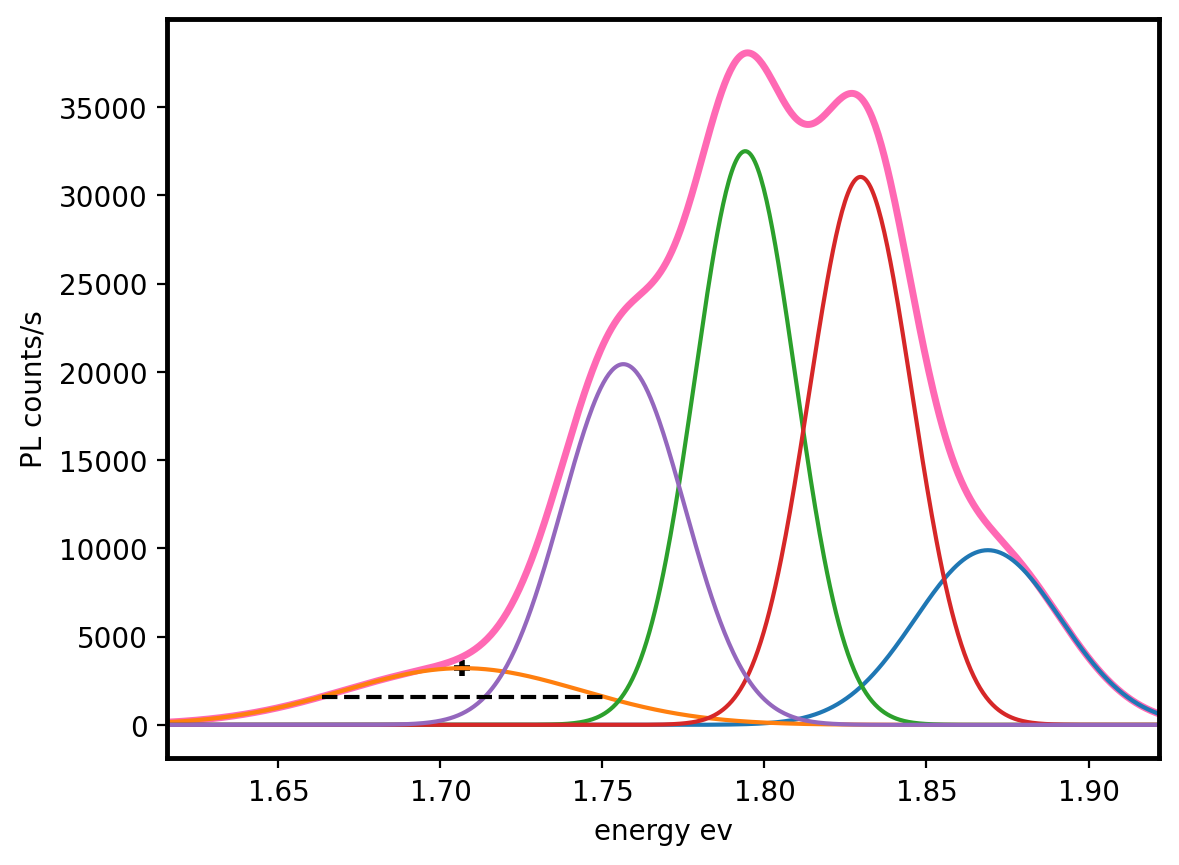

In [362]:
# scaling the fitted data back into the same intensity as the original measurement
plt.plot(X_test, pdf/np.max(pdf)*np.max(Y), color='hotpink', linewidth=2.5)

for n in range(0, pdf_individual.shape[1]):
    plt.plot(X_test, pdf_individual[:,n]/np.max(pdf)*np.max(Y))
    
plt.scatter(fitted['peakev'], fitted['intensity']/np.max(pdf)*np.max(Y), marker='+', color='k', linewidth=2)
    
plt.xlim(X_test[0], X_test[-1])
plt.plot(check_fwhm[0], check_fwhm[1]/np.max(pdf)*np.max(Y), color='k', linestyle='--')
plt.xlabel('energy ev')
plt.ylabel('PL counts/s')

plt.show()

In [119]:
import numpy as np
from sklearn.mixture import GaussianMixture


class GaussianMixture1D:
    """
    Simple class to work with 1D mixtures of Gaussians

    Parameters
    ----------
    means : array_like
        means of component distributions (default = 0)
    sigmas : array_like
        standard deviations of component distributions (default = 1)
    weights : array_like
        weight of component distributions (default = 1)
    """
    def __init__(self, means=0, sigmas=1, weights=1):
        data = np.array([t for t in np.broadcast(means, sigmas, weights)])

        components = data.shape[0]
        self._gmm = GaussianMixture(components, covariance_type='spherical')

        self._gmm.means_ = data[:, :1]
        self._gmm.weights_ = data[:, 2] / data[:, 2].sum()
        self._gmm.covariances_ = data[:, 1] ** 2

        self._gmm.precisions_cholesky_ = 1 / np.sqrt(self._gmm.covariances_)

        self._gmm.fit = None  # disable fit method for safety

    def sample(self, size):
        """Random sample"""
        return self._gmm.sample(size)

    def pdf(self, x):
        """Compute probability distribution"""

        if x.ndim == 1:
            x = x[:, np.newaxis]
        logprob = self._gmm.score_samples(x)
        return np.exp(logprob)

    def pdf_individual(self, x):
        """Compute probability distribution of each component"""

        if x.ndim == 1:
            x = x[:, np.newaxis]
        logprob = self._gmm.score_samples(x)
        responsibilities = self._gmm.predict_proba(x)
        return responsibilities * np.exp(logprob[:, np.newaxis])

In [ ]:
gm = GaussianMixture1D()


In [ ]:
test = gm.pdf_individual(X)

In [ ]:
test;

In [ ]:
plt.plot(test)
plt.show()

In [ ]:
results

In [ ]:
def get_data(fp, lower_bound, upper_bound):
        
        data = pd.read_csv(fp, header = None,skiprows=1)
        # select out the desired data from the dataframe
        x_vals = list(data.loc[:,0])
        y_vals = list(data.loc[:,1])
        
        # create and populate a list containing rounded x-values
        rounded_x = []
        for i in range(len(x_vals)):
            rounded_x.append(int(np.round(x_vals[i])))
          
        # since wavenumber does not increase by exactly 1, we need to map the 
        # desired bound to a rounded x-value and extract the index. If that 
        # value does not exist, the next closest value is taken.
        if lower_bound in rounded_x == True:
            x1_ind = rounded_x.index(lower_bound)
        else:
            x1_ind = rounded_x.index(lower_bound + 1)
          
        if upper_bound in rounded_x == True:
            x2_ind = rounded_x.index(upper_bound)
        else:
            x2_ind = rounded_x.index(upper_bound - 1)
        
        # slice the desired data down to the specified range and store
        if x2_ind > x1_ind:
            x_fit = x_vals[x1_ind:x2_ind]
            y_fit = y_vals[x1_ind:x2_ind]
        else:
            x_fit = x_vals[x2_ind:x1_ind]
            y_fit = y_vals[x2_ind:x1_ind]
        return x_fit, y_fit

In [ ]:
curves = generateY(x_fit, best_vals)


In [ ]:
params

In [ ]:
out_0

### rubber band fit

In [ ]:
## import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from natsort import natsorted
import os

##############################################################################
################################ USER INPUTS #################################
##############################################################################

args = {
    # Path to raw data
    'folder' : 'Volumes/GoogleDrive/My Drive/z_Misc/demo_raman.csv',
    # 'all' or 'All' will baseline the entire spectrum
    # a list of two values low to high will baseline over that range
    'region' : 'all'
}

##############################################################################
##############################################################################
##############################################################################

def BaselineCorrect(args):
    
    # Define the function that computes the convex hull around the spectrum  
    def rubberband(x, y):
        # Find the convex hull
        v = ConvexHull(np.array(list(zip(x, y)))).vertices
        # Rotate convex hull vertices until they start from the lowest one
        v = np.roll(v, -v.argmin())
        # Leave only the ascending part
        v = v[:v.argmax()]
    
        # Create baseline using linear interpolation between vertices
        return np.interp(x, x[v], y[v])
    # make the folder that will contain the baselined data
    new_folder = args['folder']+'_BLSub'
    os.mkdir(new_folder)
    # load files and sort by counter using natsorted()
    files = os.listdir(args['folder'])
    files = natsorted(files)
    # iterate over the file names
    for file in files:
        # define your save and import file paths
        import_path = args['folder'] +'/'+ file
        file_save_name = file.replace('.','_')
        file_save_name = file_save_name.replace('_txt','.txt')
        save_path = new_folder + '/' + file_save_name
        #  load data and sort based on wavenumber
        raw_data = pd.read_csv(import_path, header = None)
        raw_data = raw_data.sort_values(0, ignore_index = True)
        #  if a baselining of the entire spectrum is desired, this will execute
        if args['region'] == 'all' or args['region'] == 'All':
            x = raw_data[0]
            raw_y = raw_data[1]
        # if you only want a specific region, this will execute
        elif type(args['region']) == list:
            # since wavenumber does not increase by exactly 1, we need to map the 
            # desired bound to a rounded x-value and extract the index. If that 
            # value does not exist, the next closest value is taken.
            def get_data(raw_data, lower_bound, upper_bound):       
                #select out the desired data from the dataframe
                x_vals = list(raw_data[0])
                y_vals = list(raw_data[1])                
                #create and populate a list containing rounded x-values
                rounded_x = []
                for i in range(len(x_vals)):
                    rounded_x.append(int(np.round(x_vals[i])))
                # Find the index of the lower bound. Once it is found, break
                for i in range(4):
                    if (lower_bound + i in rounded_x) == True:
                        x1_ind = rounded_x.index(lower_bound + i)
                        break
                # Find the index of the upper bound. Once it is found, break
                for i in range(4):
                    if (upper_bound - i in rounded_x) == True:
                        x2_ind = rounded_x.index(upper_bound - i)
                        break                        
                # slice the desired data down to the specified range and store
                x_fit = pd.Series(x_vals[x1_ind:x2_ind])
                y_fit = pd.Series(y_vals[x1_ind:x2_ind])
                return x_fit, y_fit
            # Call the function
            x, raw_y = get_data(raw_data, args['region'][0], args['region'][1])           
        # Run the rubberband function and subtarct the baseline from the spectrum
        fit_y = raw_y - rubberband(x, raw_y)
        # Make the data into a dataframe and save it
        export = pd.DataFrame(zip(x,fit_y))
        export.to_csv(save_path, index = None, header = None)
 # Call the function
BaselineCorrect(args)

In [640]:
x = np.arange(0,70, 1)

In [643]:
y = np.ones_like(x)*25

In [644]:
y[50:] = 230

array([ 25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25, 230, 230,
       230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
       230, 230, 230, 230, 230])

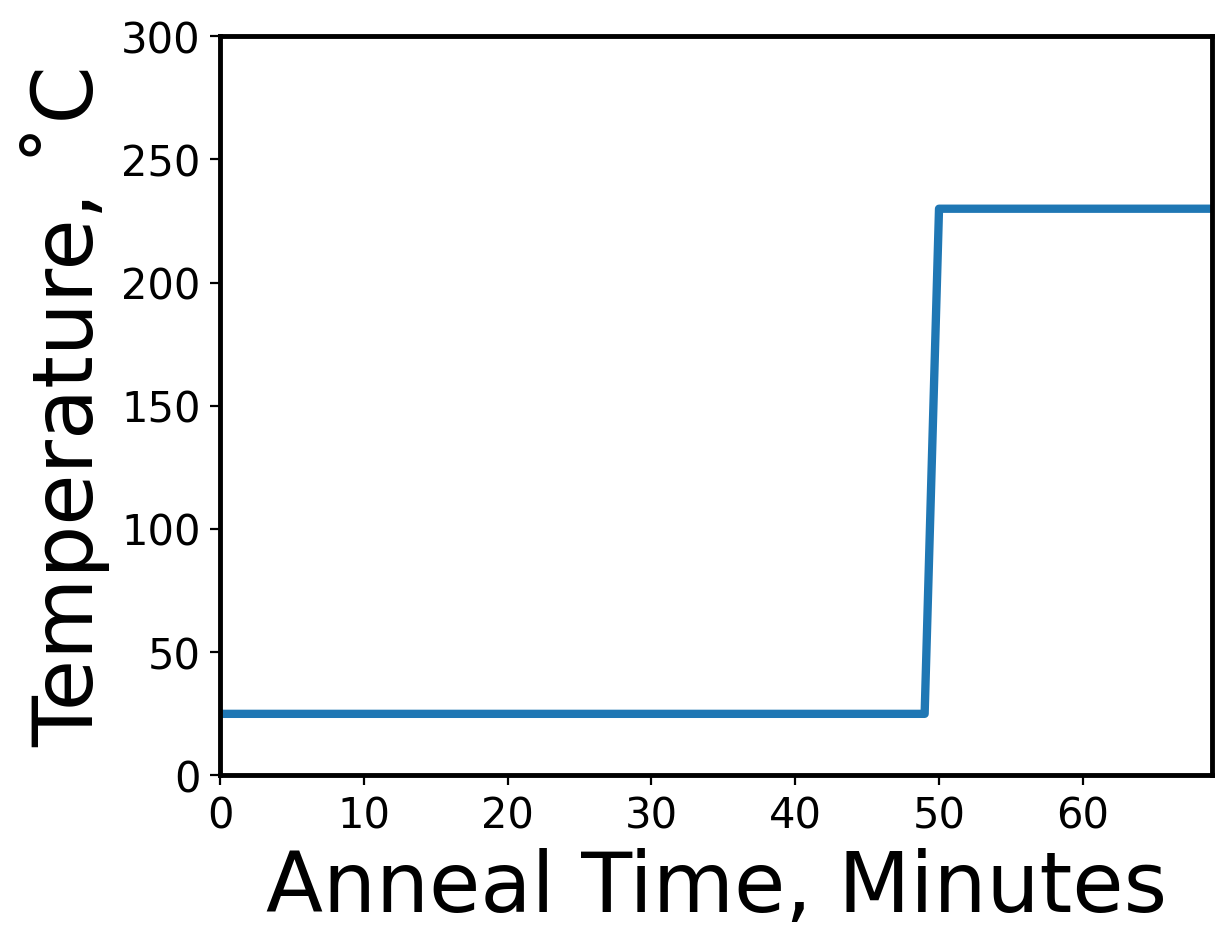

In [657]:
plt.plot(x,y, linewidth=3)

plt.ylabel('Temperature, ˚C', size=30)

plt.xlabel('Anneal Time, Minutes', size=30)

plt.xlim(x[0], x[-1])

plt.ylim(0, 300)

plt.xticks(size=15)
plt.yticks(size=15)

plt.show()